## Chapter 15: Recurrent networks 

In [ ]:
There are

# 15.3  Variable order dynamic systems 

In [2]:
## This code cell will not be shown in the HTML version of this notebook
# imports from custom library
import sys
sys.path.append('../../')
from mlrefined_libraries import math_optimization_library as optlib
from mlrefined_libraries import nonlinear_superlearn_library as nonlib
from mlrefined_libraries import recurrent_library as recurlib

# demos for this notebook
regress_plotter = nonlib.nonlinear_regression_demos
static_plotter = optlib.static_plotter.Visualizer()
basic_runner = nonlib.basic_runner
datapath = '../../mlrefined_datasets/nonlinear_superlearn_datasets/'

# import autograd functionality to bulid function's properly for optimizers
import autograd.numpy as np

# import timer
from datetime import datetime 
import copy
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.font_manager import FontProperties

# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

## 15.3.1  A prototypical example: the exponential average

In Section 15.2.1 we discussed the *moving average* - a filtering or smoothing technique that is a prototypical example of a dynamic system with fixed order.  Here we discuss an analagous smoothing technique called *exponential averaging* or *running average* - that equally well provides a prototype for dynamic systems with *variable order*.

The running average is another smoothing technique - often applied to time series data as a pre-processing step to make it easier to further analyze and work with.  Instead of taking a sliding window and averaging the input series inside of it we compute the average of the *entire input sequence* in an online fashion, adding the contribution of each input one element at-a-time. To do this we form an average of the first two points first two points $x_1$ and $x_2$ of an ordered input sequence (like the time series below) $x_1,\,x_2,...,x_P$.  We then take this result, and make a weighted combination of it and the third point $x_3$ giving an average of the first three points.  We continue in this fashion until the final element of the sequence $x_P$ is reached.

### DEMO 1 - MIRRORING DEMO 1 OF 15.2.1

### DEMO 2 - MIRRORING DEMO 2 OF 15.2.1


Because at each step we need only worry about the contribution of the next point, the running average is (as we will see below) both more computationally effecient than the moving average idea, and simultaneously employs *an entire history* of the input data at each update step (as opposed to the comparitively short history provided by  the fixed order of a moving average window).

Instead of a running sum, lets compute a running *average* of the numbers $x_1,\,x_1,\,...,x_P$.  First, we can write it naively (like we first did the running sums above) as

\begin{array}
\
\text{average of the first $0$ elements:} \,\,\,\,\,\,\,\,\,\,\,\,\, h_1 = 0 \\
\text{average of the first $1$ elements:} \,\,\,\,\,\,\,\,\,\,\,\,\, h_2 = x_1 \\
\text{average of the first $2$ elements:} \,\,\,\,\,\,\,\,\,\,\,\,\, h_3 = \frac{x_1 + x_2}{2} \\
\text{average of the first $3$ elements:} \,\,\,\,\,\,\,\,\,\,\,\,\, h_4 = \frac{x_1 + x_2 + x_3}{3} \\
\text{average of the first $4$ elements:} \,\,\,\,\,\,\,\,\,\,\,\,\, h_5 = \frac{x_1 + x_2 + x_3 + x_4}{4} \\
\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, \vdots \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, \vdots \\
\text{average of the first $p$ elements:} \,\,\,\,\,\,\,\,\,\,\,\,\, h_{p+1} = \frac{x_1 + x_2 + x_3 + x_4 + \cdots  + x_p}{p} \\
\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, \vdots \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, \vdots \\
\text{average of the first $P$ elements:} \,\,\,\,\,\,\,\,\,\,\,\,\ h_{P+1} = \frac{x_1 + x_2 + x_3 + x_4 + \cdots + x_p + x_{p+1} + \cdots + x_P}{P}.
\end{array}

As with the running sums discussed above, here we can indeed write the running average as a *dynamic system with memory* of order $\mathcal{O} = 1$.  First notice that the second average $h_3$ can be written in terms of the first $h_2$ as

\begin{equation}
h_3 = \frac{x_1 + x_2}{2} = \frac{h_2 + x_2}{2} = \frac{1}{2}h_2 + \frac{1}{2}x_2.
\end{equation}

Likeiwse we can write $h_4$ in terms of its predecessor $h_3$ as 

\begin{equation}
h_4 = \frac{x_1 + x_2 + x_3}{3} = \frac{2\frac{x_1 + x_2}{2} + x_3}{3} = \frac{2h_3 + x_3}{3} = \frac{2}{3}h_3 + \frac{1}{3}x_3
\end{equation}

Likewise we can more generally re-write the $p^{th}$ average $h_{p+1}$ in the same sort of way as

\begin{equation}
h_{p+1} = \frac{p-1}{p}h_p + \frac{1}{p}x_p.
\end{equation}

And so we cxan write the running average of a sequence of inputs $x_1,\,x_2\,...,x_P$ as a dynamic system *with memory* as

\begin{array}
\
h_1 = 0 \\
h_{p+1} = \frac{p-1}{p}h_p + \frac{1}{p}x_p \,\,\,\,\,\,\,\,\,\, p = 1,...,P.
\end{array}

Note here that our state variable $h_{p+1}$ does indeed 'summarize' the state of the *input* sequence at the $\left(p+1\right)^{th}$ step of system process: here it is precisely the average of the first $p$ input elements $x_1$ through $x_p$. 

## 15.3.1  Some examples

Say we have a sequence of $P$ numbers $x_1,\,x_2,\,...,x_P$ listed in order from $p=1$ to $p=P$, and based on this we want to build another sequence $h_1,\,h_2\,...,h_{P+1}$ of $P+1$ *running sums* of this input whose $\left(\,p+1\right)^{th}$ element is the sum of the first $p$ numbers from our list.  In other words, the elements of our constructed sequence look like

\begin{array}
\
\text{sum of the first $0$ elements:} \,\,\,\,\,\,\,\,\,\,\,\,\, h_1 = 0 \\
\text{sum of the first $1$ elements:} \,\,\,\,\,\,\,\,\,\,\,\,\, h_2 = x_1 \\
\text{sum of the first $2$ elements:} \,\,\,\,\,\,\,\,\,\,\,\,\, h_3 = x_1 + x_2 \\
\text{sum of the first $3$ elements:} \,\,\,\,\,\,\,\,\,\,\,\,\, h_4 = x_1 + x_2 + x_3 \\
\text{sum of the first $4$ elements:} \,\,\,\,\,\,\,\,\,\,\,\,\, h_5 = x_1 + x_2 + x_3 + x_4 \\
\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, \vdots \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, \vdots \\
\text{sum of the first $p$ elements:} \,\,\,\,\,\,\,\,\,\,\,\,\, h_{p+1} = x_1 + x_2 + x_3 + x_4 + \cdots  + x_p \\
\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, \vdots \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, \vdots \\
\text{sum of the first $P$ elements:} \,\,\,\,\,\,\,\,\,\,\,\,\ h_{P+1} = x_1 + x_2 + x_3 + x_4 + \cdots + x_p + x_{p+1} + \cdots + x_P.
\end{array}

Here the first term $h_1$ (the sum of the first $0$ elements) is redundant and we could exclude it if we wanted too (we include it for sake of completeness, and because it will help us keep our indecies in line with the previous Section in what follows below).

Now notice a simple fact: there is no way to express the sequence $\left\{ h_p \right\}_{p=1}^{P+1}$ of running sums (as written above) as a *memoryless* dynamic system - using a formula to express each update step employing the same mathematical function at each step - of any *fixed* order (as introduced in the previous Section).  That is, we cannot express each update step of the running sum using the kind of formulae we saw in the previous Section.  Why? 

Because notice that at the $\left(p+1\right)^{th}$ step in its construction the running sum $h_{p+1}$ requires *complete memory* of the input sequence up to that point - from the very first input element $x_1$ all the way to $x_p$.  That is, the *order* of the system increases at each step.  This is *not* how a memoryless dynamic system works: with such a system at each step its *memory* is limited to a *fixed order* or number of elements in the past [[1]]((#endnotes)).  In order to express the running sums above using a single formula update we need to extend the dynamic systems framework we have just seen - to have *memory*. 

In order to do this first notice that if we were to compute a sequence of running sums in practice we would never use the form of the steps given above - they're very ineffecient.  In the naive manner written above, the running sums update steps

1.  **waste computation:** the computation done to produce each element $h_p$ is *repeated in full* in the next update $h_{p+1}$  (e.g., look at how the computation of $h_2$ is repeated again when forming $h_3$, and so on)
2.  **waste 'RAM':** in order to compute $h_{p+1}$ we need to remember every input element from $x_1$ all the way to $x_p$ (e.g., notice how computing $h_4$ we need access to $x_1$, $x_2$, and $x_3$, and so on)

We would not compute a set of running sums in the manner shown above.  Instead we would use *substitution* - since each subsequent running sum terms adds in the next element of the input sequence - and write the sequence of running sums equivalently as 


\begin{array}
\
\text{sum of the first $0$ elements:} \,\,\,\,\,\,\,\,\,\,\,\,\, h_1 = 0 \\
\text{sum of the first $1$ elements:} \,\,\,\,\,\,\,\,\,\,\,\,\, h_2 = x_1 \\
\text{sum of the first $2$ elements:} \,\,\,\,\,\,\,\,\,\,\,\,\, h_3 = h_1 + x_2 \\
\text{sum of the first $3$ elements:} \,\,\,\,\,\,\,\,\,\,\,\,\, h_4 = h_2 + x_3 \\
\text{sum of the first $4$ elements:} \,\,\,\,\,\,\,\,\,\,\,\,\, h_5 = h_3 + x_4 \\
\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, \vdots \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, \vdots \\
\text{sum of the first $p$ elements:} \,\,\,\,\,\,\,\,\,\,\,\,\, h_{p+1} = h_p + x_p \\
\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, \vdots \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, \vdots \\
\text{sum of the first $P$ elements:} \,\,\,\,\,\,\,\,\,\,\,\,\ h_{P+1} = h_P + x_P.
\end{array}

which we write in short as 

\begin{array}
\
h_1 = 0 \\
h_{p+1} = h_p + x_{p} \,\,\,\,\,\, p = 1,...,P.
\end{array}

This manner of writing the running sums eliminates both of the problems with the naive way we first wrote it above.  First off, we do not repeat the same computation from $h_p$ to $h_{p+1}$ - that is summing up $x_1$ through $x_{p-1}$ again - since we simply re-use the former $h_{p}$ and add the next input $x_p$ in computing $h_{p+1}$.  Secondly we need not remember each and every input when computing $h_{p+1}$, just $x_p$ and the predecessor $h_{p}$ [[2]](#endnotes).  So - in other words - the update formulae above each have *order $\mathcal{O} = 1$* in $h_p$ and $x_p$. 

This new more effecient way of writing the running sums now takes the form of a dynamic system - in that it is a simple update formula that completely describes each step of the running sum sequence.  However as opposed to those systems discussed in the previous Section, this kind of dynamic system is said to *have memory*.  Why?  Because the sequence (of running sums) defined here has a 'complete memory' of the input sequence at each step, in the sense that the term $h_{p+1}$ is constructed using every single input $x_1$ through $x_p$.  This is opposed to any order $\mathcal{O}$ *memoryless* system we might define on the input sequence, where each update is dependent on *only* the previous $\mathcal{O}$ terms.  

The *running sums* example here is an example of a dynamic system *with memory*, which takes the general form

\begin{array}
\
h_1 = \gamma \\
h_{p+1} = f\left(h_p, x_{p}\right) \,\,\,\,\,\, p = 1,...,P
\end{array}

where $h_1$ is again referred to as the system's *initial condition* of the sequence $\left\{ h_p \right\}_{p=1}^{P+1}$.  This kind of system has order $\mathcal{O} = 1$ because each update depends on only the single preceeding element $h_p$ and input $x_p$, and we can generalize it similarly to the way we did *memoryless* systems in the previous Section (which we will do below after going through additional examples).  

Notice in the case of the running sums how $h_{p+1}$ *summarizes* the first $p$ input elements $x_1,\,x_2,...,x_p$ - by literally *summing* them up.  This idea generalizes to any *dynamic systems with memory* in general as well: the element $h_{p+1}$ *summarizes the system* of inputs $x_1,\,x_2,...,x_p$.  This is what gives such a dynamic system 'memory', and differentiates it from those we saw in the previous Section.  This memory is not necssarily $100%$ accurate - e.g,. in the case of the running sums the sum $h_{p+1}$ while constructed from $x_1$ through $x_p$ could be made using any number of $p$ numbers - but nonetheless $h_{p+1}$ encodes *something* about the input sequence up to its $p_{th}$ element.  

For the same reason one often says that $h_{p+1}$ *summarizes the state of the (input) system* at each step e.g., in the instance of the running sums we have just seen $h_{p+1}$ is literally the sum $x_1$ through $x_p$.  It is for this reason that the $h_{p+1}$ is often referred to as the *state variable* or *state sequence* of a dynamic system with memory.

> The element $h_{p+1}$ *summarizes the system* of inputs $x_1,\,x_2,...,x_p$, which is what gives a dynamic system 'memory'.  For the same reason one often says that $h_{p+1}$ *summarizes the state of the (input) system* at each step.

#### <span style="color:#a50e3e;">Example 2. </span>  A simple model of a savings account balance

The running sum described above is often used as a simple model of yuor savings account balance.  Suppose that we measure our income (that is - our pay minus all expenses) at the end of each month for $P$ consecutive months, and denote this by the sequence $x_1,\,x_2,\,...,x_P$.  At the end of each period we take any positive income we gained from the previous one and put it into savings (for simplicity we assume we gain no interest on this).  If our income was negative, our expenses were greater than our monthly income, we dip into savings to cover our costs.  

At month $p=1$ suppose we start off with zero dollars in savings, which we denote by $h_1 = 0$.  At the end of the first month we tally up our income $x_1$, and at the start of the second month $p=2$ we add or subratc this value from our savings as

\begin{equation}
h_2 = h_1 + x_1.
\end{equation}

Suppose for simplicity we can have 'negative' savings (i.e., we can borrow money from the bank interest free).

At the end of the second month we again tally up our total monthly income $x_2$ and add / subtract it from our savings account balance, giving 

\begin{equation}
h_3 = h_2 + x_2.
\end{equation}

And we can go on and on producing an entire sequence of savings measurements $h_1,\,h_2,\,...,h_P,\,h_{P+1}$ via this *running sum* dynamic system

\begin{array}
\
h_1 = 0 \\
h_{p+1} = h_{p} + x_{p}  \,\,\,\,\,\, p = 1,...,P.
\end{array}

Here the state variable $h_{p}$ summarizes the input sequence - your monthly incomes - up to time $p$ as a literal sum of all incomes up to that time period $x_1$ through $x_p$. 

Below we simulate and then plot (in blue) a sequence of $P$ monthly incomes uniformly on the interval $\left[-1,+1\right]$, and generate the associated savings history (shown in magenta).

<IPython.core.display.Javascript object>


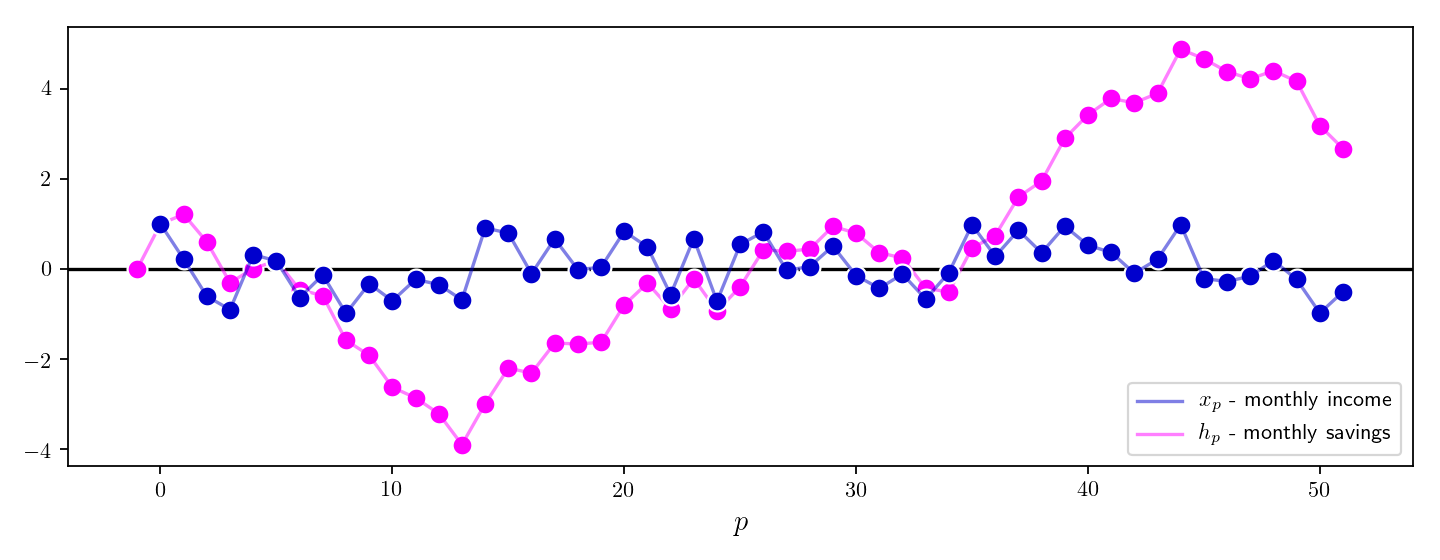

In [76]:
## This code cell will not be shown in the HTML version of this notebook
# running sum
def running_sum(h_p,x_p):
    return x_p + h_p

# create simulated monthly income
num_elements = 52
monthly_income = []
monthly_savings = [np.array([0])]
for p in range(num_elements):
    # make monthly income
    x_p = (-1)**np.round(np.random.rand(1))
    x_p = 2*np.random.rand(1) - 1
    monthly_income.append(x_p)
    
    # make monthly savings level
    h_p = monthly_savings[p]
    h_p_1 = h_p + x_p
    monthly_savings.append(h_p_1)
    
### plot the result ###
# setup figure 
fig = plt.figure(figsize = (9,3.5))
gs = gridspec.GridSpec(1, 1) 
ax = plt.subplot(gs[0]);

ax.scatter(np.arange(len(monthly_income)),monthly_income,c = 'mediumblue',edgecolor = 'w',s = 80,linewidth = 1,zorder = 3);
ax.plot(monthly_income,alpha = 0.5,c = 'mediumblue',zorder = 3);

ax.scatter(np.arange(-1,len(monthly_savings)-1),monthly_savings,c = 'fuchsia',edgecolor = 'w',s = 80,linewidth = 1,zorder = 2);
ax.plot(np.arange(-1,len(monthly_savings)-1),monthly_savings,alpha = 0.5,c = 'fuchsia',zorder = 2);

# label axes
ax.axhline(c = 'k',zorder = 0)
ax.set_xlabel(r'$p$',fontsize = 13)
ax.legend(['$x_p$ - monthly income','$h_p$ - monthly savings'],loc='lower right')

#### <span style="color:#a50e3e;">Example 3. </span>  Running averages

Instead of a running sum, lets compute a running *average* of the numbers $x_1,\,x_1,\,...,x_P$.  First, we can write it naively (like we first did the running sums above) as

\begin{array}
\
\text{average of the first $0$ elements:} \,\,\,\,\,\,\,\,\,\,\,\,\, h_1 = 0 \\
\text{average of the first $1$ elements:} \,\,\,\,\,\,\,\,\,\,\,\,\, h_2 = x_1 \\
\text{average of the first $2$ elements:} \,\,\,\,\,\,\,\,\,\,\,\,\, h_3 = \frac{x_1 + x_2}{2} \\
\text{average of the first $3$ elements:} \,\,\,\,\,\,\,\,\,\,\,\,\, h_4 = \frac{x_1 + x_2 + x_3}{3} \\
\text{average of the first $4$ elements:} \,\,\,\,\,\,\,\,\,\,\,\,\, h_5 = \frac{x_1 + x_2 + x_3 + x_4}{4} \\
\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, \vdots \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, \vdots \\
\text{average of the first $p$ elements:} \,\,\,\,\,\,\,\,\,\,\,\,\, h_{p+1} = \frac{x_1 + x_2 + x_3 + x_4 + \cdots  + x_p}{p} \\
\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, \vdots \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, \vdots \\
\text{average of the first $P$ elements:} \,\,\,\,\,\,\,\,\,\,\,\,\ h_{P+1} = \frac{x_1 + x_2 + x_3 + x_4 + \cdots + x_p + x_{p+1} + \cdots + x_P}{P}.
\end{array}

As with the running sums discussed above, here we can indeed write the running average as a *dynamic system with memory* of order $\mathcal{O} = 1$.  First notice that the second average $h_3$ can be written in terms of the first $h_2$ as

\begin{equation}
h_3 = \frac{x_1 + x_2}{2} = \frac{h_2 + x_2}{2} = \frac{1}{2}h_2 + \frac{1}{2}x_2.
\end{equation}

Likeiwse we can write $h_4$ in terms of its predecessor $h_3$ as 

\begin{equation}
h_4 = \frac{x_1 + x_2 + x_3}{3} = \frac{2\frac{x_1 + x_2}{2} + x_3}{3} = \frac{2h_3 + x_3}{3} = \frac{2}{3}h_3 + \frac{1}{3}x_3
\end{equation}

Likewise we can more generally re-write the $p^{th}$ average $h_{p+1}$ in the same sort of way as

\begin{equation}
h_{p+1} = \frac{p-1}{p}h_p + \frac{1}{p}x_p.
\end{equation}

And so we cxan write the running average of a sequence of inputs $x_1,\,x_2\,...,x_P$ as a dynamic system *with memory* as

\begin{array}
\
h_1 = 0 \\
h_{p+1} = \frac{p-1}{p}h_p + \frac{1}{p}x_p \,\,\,\,\,\,\,\,\,\, p = 1,...,P.
\end{array}

Note here that our state variable $h_{p+1}$ does indeed 'summarize' the state of the *input* sequence at the $\left(p+1\right)^{th}$ step of system process: here it is precisely the average of the first $p$ input elements $x_1$ through $x_p$. 

<IPython.core.display.Javascript object>


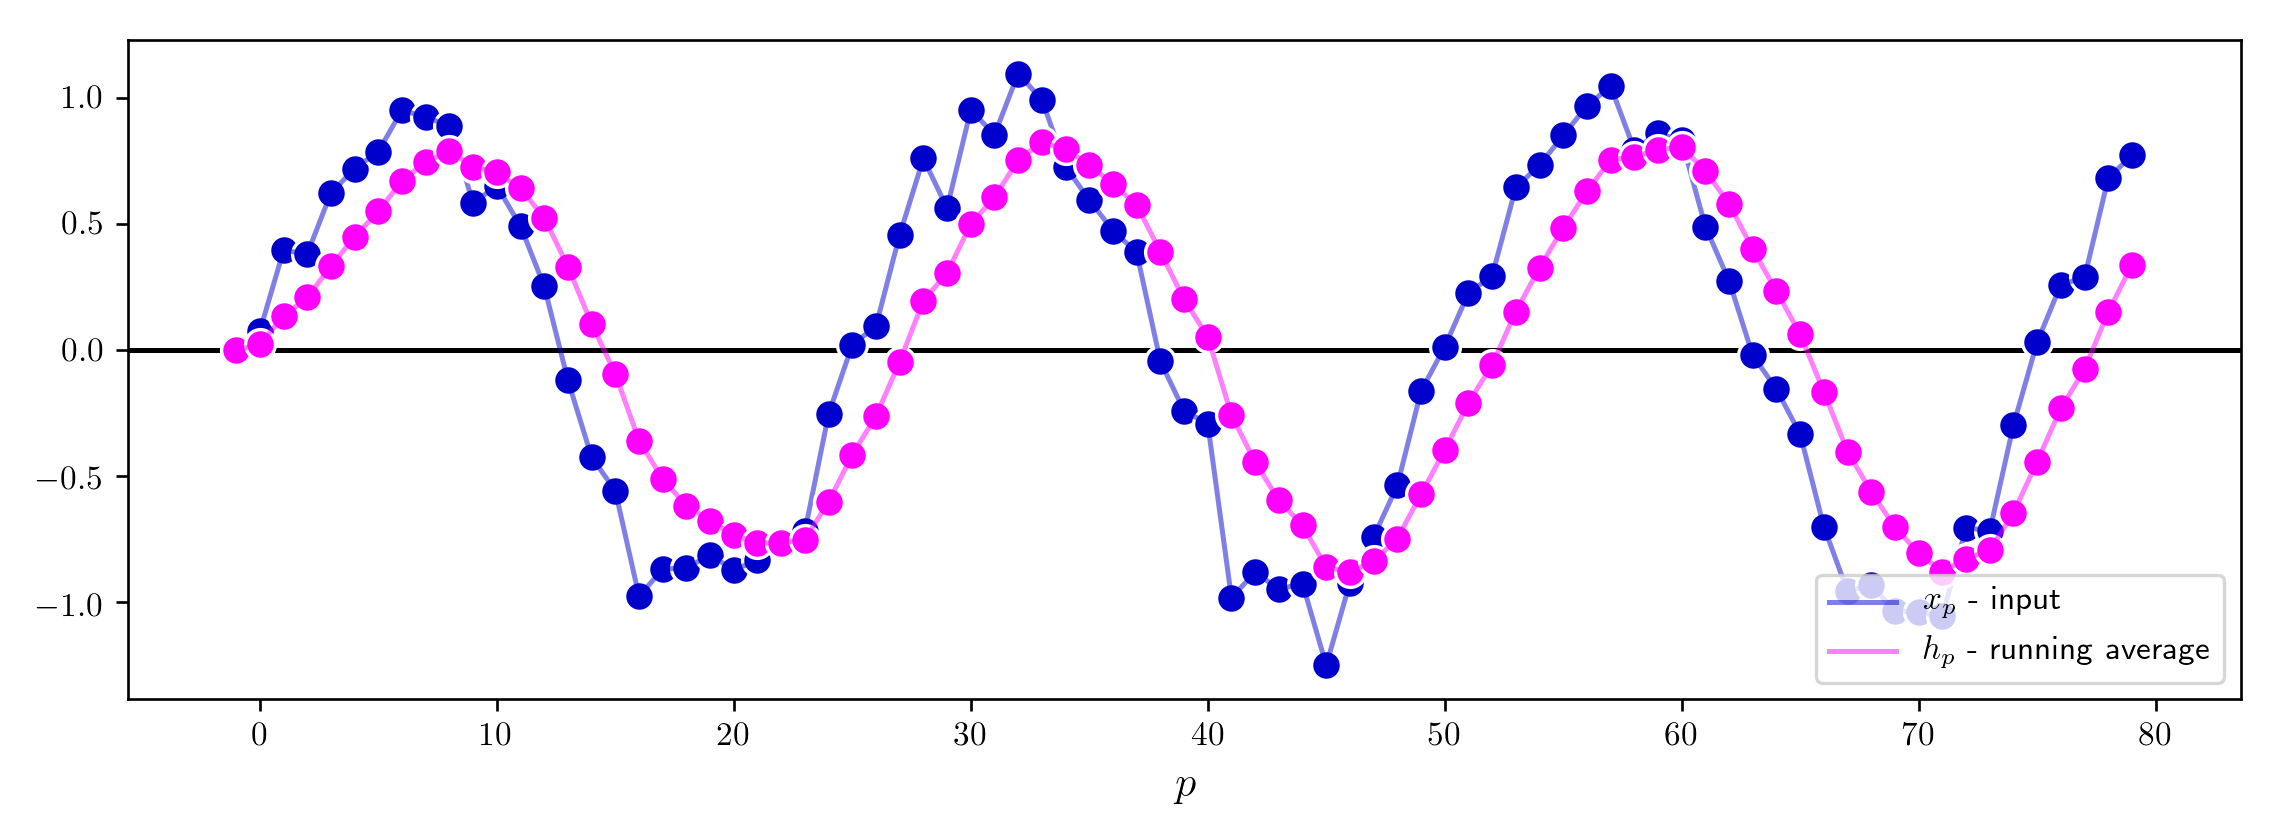

In [5]:
## This code cell will not be shown in the HTML version of this notebook
# running sum
def running_ave_1(h_p,x_p,p):
    return (p-1)/float(p)*h_p + 1/float(p)*x_p

def running_ave(h_p,x_p,p):
    return 0.7*h_p + 0.3*x_p

# create simulated monthly income
num_elements = 80
input_data = []
running_data = [np.array([0])]
for p in range(num_elements):
    # make monthly income
    x_p = np.sin(0.25*p) + 0.1*np.random.randn(1)
    input_data.append(x_p)
    
    h_p = running_data[-1]
    h_p_plus1 = running_ave(h_p,x_p,p+1)
    running_data.append(h_p_plus1)
    
### plot the result ###
# setup figure 
fig = plt.figure(figsize = (9.5,3.5))
gs = gridspec.GridSpec(1, 1) 
ax = plt.subplot(gs[0]);

ax.scatter(np.arange(len(input_data)),input_data,c = 'mediumblue',edgecolor = 'w',s = 80,linewidth = 1,zorder = 2);
ax.plot(input_data,alpha = 0.5,c = 'mediumblue',zorder = 2);

ax.scatter(np.arange(-1,len(running_data)-1),running_data,c = 'fuchsia',edgecolor = 'w',s = 80,linewidth = 1,zorder = 3);
ax.plot(np.arange(-1,len(running_data)-1),running_data,alpha = 0.5,c = 'fuchsia',zorder = 3);

# label axes
ax.axhline(c = 'k',zorder = 0)
ax.set_xlabel(r'$p$',fontsize = 13)
ax.legend(['$x_p$ - input','$h_p$ - running average'],loc='lower right')

<IPython.core.display.Javascript object>


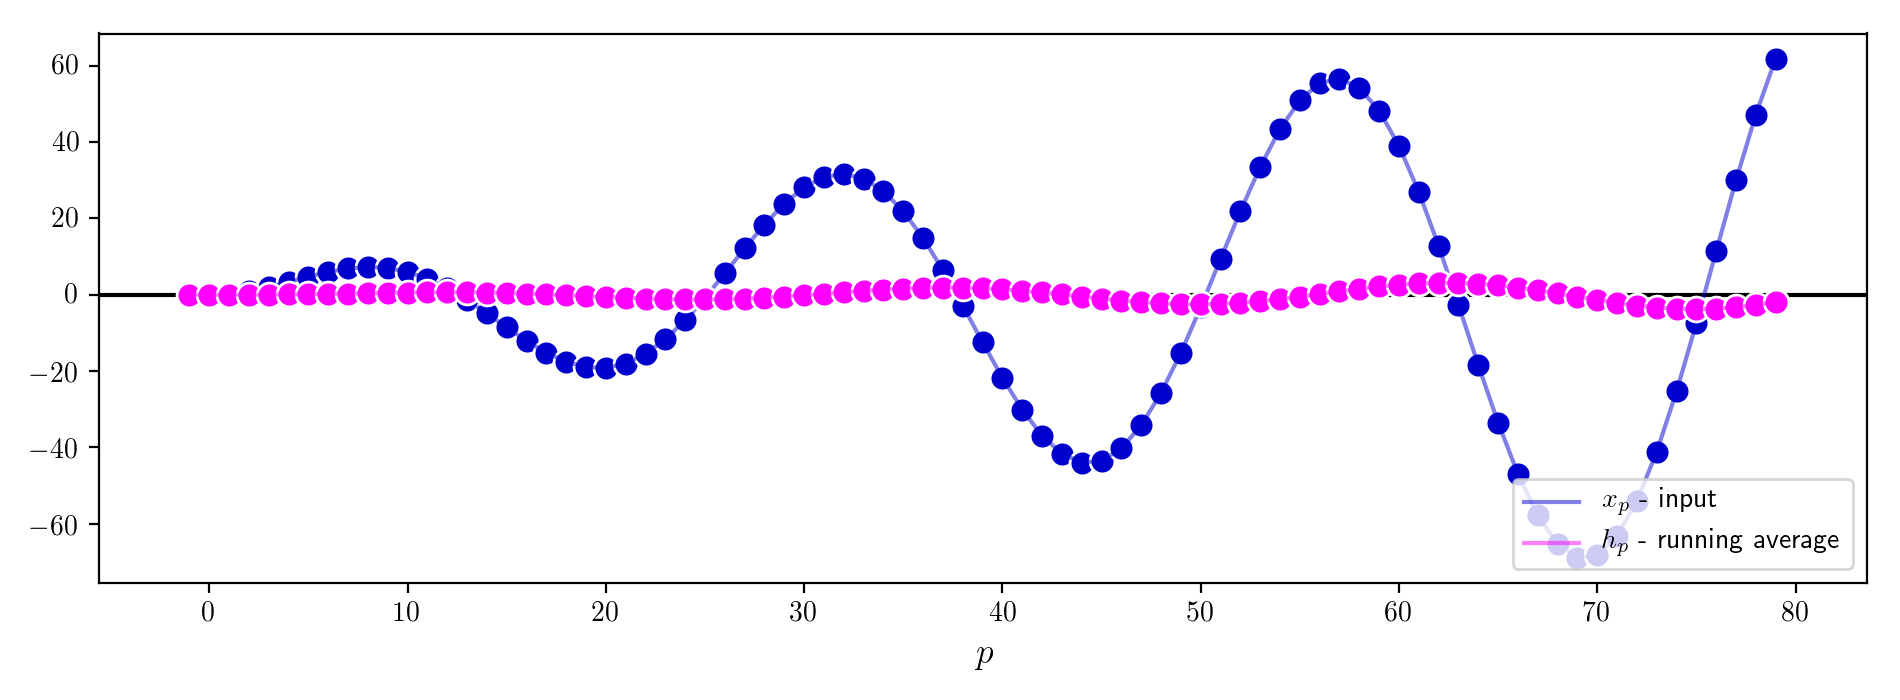

In [22]:
## This code cell will not be shown in the HTML version of this notebook
# running sum
def running_riemann(h_p,x_p,D):
    return h_p + 1/float(D)*x_p

# create simulated monthly income
num_elements = 80
input_data = []
running_data = [np.array([0])]
for p in range(num_elements):
    # make monthly income
    x_p = p*np.sin(0.25*p) #+ 0.1*np.random.randn(1)
    input_data.append(x_p)
    
    h_p = running_data[-1]
    h_p_plus1 = running_riemann(h_p,x_p,num_elements)
    running_data.append(h_p_plus1)
    
### plot the result ###
# setup figure 
fig = plt.figure(figsize = (9.5,3.5))
gs = gridspec.GridSpec(1, 1) 
ax = plt.subplot(gs[0]);

ax.scatter(np.arange(len(input_data)),input_data,c = 'mediumblue',edgecolor = 'w',s = 80,linewidth = 1,zorder = 2);
ax.plot(input_data,alpha = 0.5,c = 'mediumblue',zorder = 2);

ax.scatter(np.arange(-1,len(running_data)-1),running_data,c = 'fuchsia',edgecolor = 'w',s = 80,linewidth = 1,zorder = 3);
ax.plot(np.arange(-1,len(running_data)-1),running_data,alpha = 0.5,c = 'fuchsia',zorder = 3);

# label axes
ax.axhline(c = 'k',zorder = 0)
ax.set_xlabel(r'$p$',fontsize = 13)
ax.legend(['$x_p$ - input','$h_p$ - running average'],loc='lower right')

#### <span style="color:#a50e3e;">Example 2. </span>  The running Riemann sum 

In the instance that $x_1,\,x_2,\,...,x_P$ are $P$ ordered evaluations of a function spaced $\frac{1}{D}$ apart, a slight adjustment to the running sum gives an approximation to the one-dimensional integral or 'area under the curve', known as a *Riemann sum*.  As illustrated in the figure below the *Riemann sum* approximates the area under a curve by a series of equally spaced rectangles whose heights are equally spaced evaluations of the function.

PICTURE GOES HERE

The Riemann sum of a function up to the $p^{th}$ evaluation $x_p$ is just the sum of the area of the rectangles defined by it and its predecessors, that is 

\begin{equation}
h_{p+1} = \frac{1}{D}x_1 + \frac{1}{D}x_2 + \cdots + \frac{1}{D}x_{p-1} + \frac{1}{D}x_{p}
\end{equation}

which - like the running sum (here we are just multiplying the same step by $\frac{1}{D}$) - can be defined in terms of its predecessor simply as 

\begin{equation}
h_{p+1} = \left(\frac{1}{D}x_1 + \frac{1}{D}x_2 + \cdots + \frac{1}{D}x_{p-1}\right) + \frac{1}{D}x_{p} = h_p + \frac{1}{D}x_p.
\end{equation}

So the running Riemann sum can be written very similarly to the running sum as

\begin{array}
\
h_1 = 0 \\
h_{p+1} = h_p + \frac{1}{D}x_{p} \,\,\,\,\,\, p = 1,...,P.
\end{array}

Here the state variable $h_{p+1}$ summarizes the input from $x_1$ through $x_p$ in that it precisely the Reimann sum of the rectangles with these heights.

#### <span style="color:#a50e3e;">Example 4. </span>  Running product

We can just as easily show that a running *product* of the numbers $x_1,\,x_1,\,...,x_P$ can also be written as a dynamic system with memory.  Setting the initial condition $h_1 = 1$ the $p^{th}$ such product could be written naively as 

\begin{equation}
h_{p+1} = x_1\cdot x_2 \cdots  x_{p-1}\cdot x_p.
\end{equation}

However just as with the running sum we can easily write this recursively in terms of its predecessor as 

\begin{equation}
h_{p+1} = h_p \cdot x_p.
\end{equation}


So we can write the running product in general as a dynamic system with memory as  

\begin{array}
\
h_1 = 1 \\
h_{p+1} = h_p \cdot x_p \,\,\,\,\,\,\,\,\,\, p = 1,...,P.
\end{array}

Once again the state variable $h_{p+1}$ does indeed *summarize* the input sequence up to this step - as the product of the first $p$ numbers $x_1$ through $x_p$.

#### <span style="color:#a50e3e;">Example 4. </span>  Historical maximum

<IPython.core.display.Javascript object>


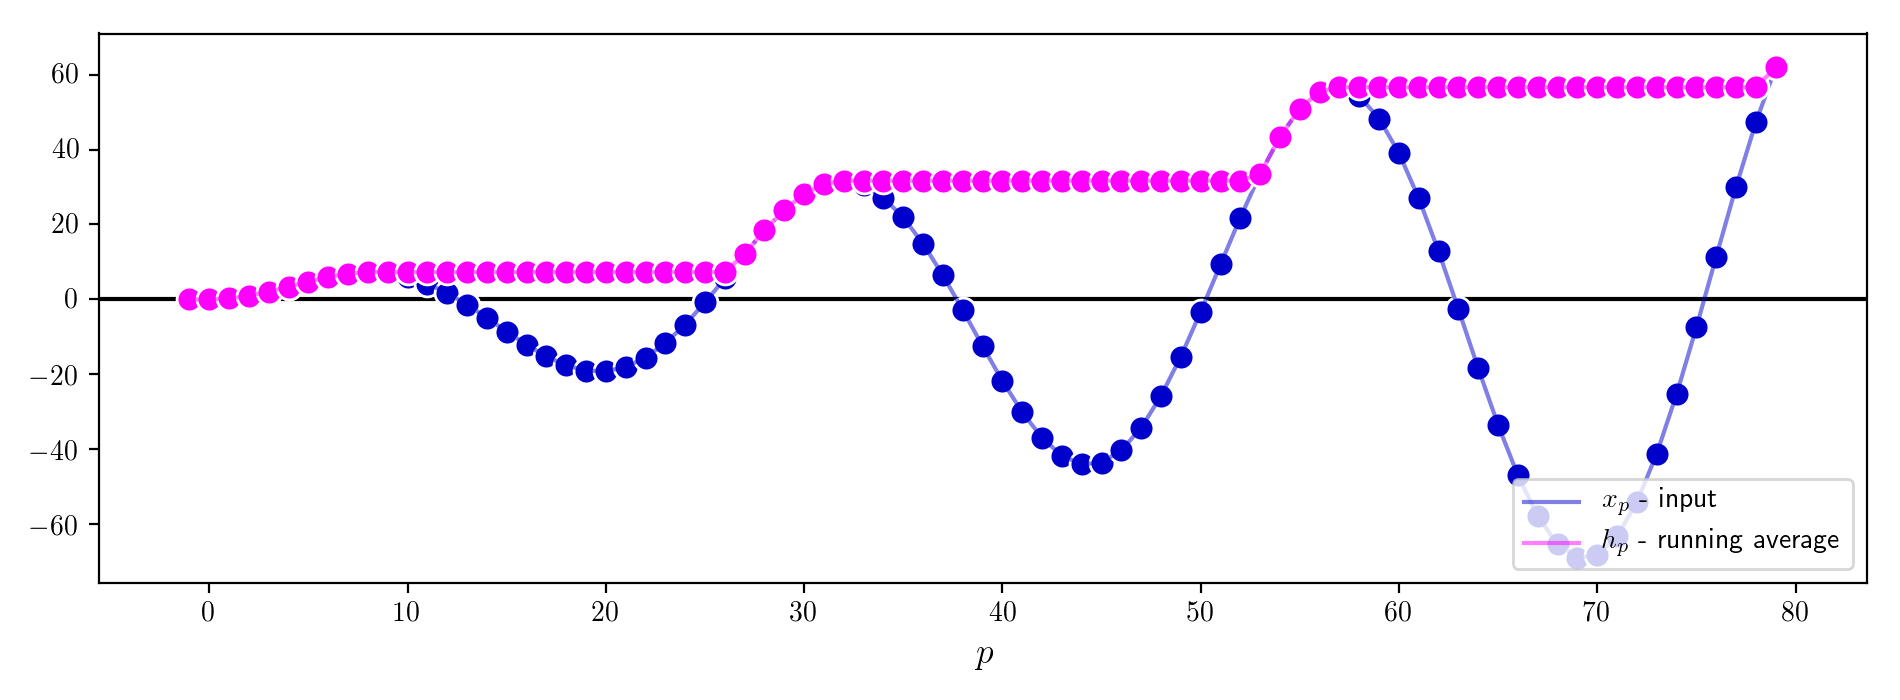

In [32]:
## This code cell will not be shown in the HTML version of this notebook
# running sum
def running_product(h_p,x_p,D):
    return np.maximum(h_p,x_p)

# create simulated monthly income
num_elements = 80
input_data = []
running_data = [np.array([0])]
for p in range(num_elements):
    # make monthly income
    x_p = p*np.sin(0.25*p) #+ 0.1*np.random.randn(1)
    input_data.append(x_p)
    
    h_p = running_data[-1]
    h_p_plus1 = running_product(h_p,x_p,num_elements)
    running_data.append(h_p_plus1)
    
### plot the result ###
# setup figure 
fig = plt.figure(figsize = (9.5,3.5))
gs = gridspec.GridSpec(1, 1) 
ax = plt.subplot(gs[0]);

ax.scatter(np.arange(len(input_data)),input_data,c = 'mediumblue',edgecolor = 'w',s = 80,linewidth = 1,zorder = 2);
ax.plot(input_data,alpha = 0.5,c = 'mediumblue',zorder = 2);

ax.scatter(np.arange(-1,len(running_data)-1),running_data,c = 'fuchsia',edgecolor = 'w',s = 80,linewidth = 1,zorder = 3);
ax.plot(np.arange(-1,len(running_data)-1),running_data,alpha = 0.5,c = 'fuchsia',zorder = 3);

# label axes
ax.axhline(c = 'k',zorder = 0)
ax.set_xlabel(r'$p$',fontsize = 13)
ax.legend(['$x_p$ - input','$h_p$ - running average'],loc='lower right')

# Input / output systems

In [112]:
# create frequency information to modulate signal with
t,f = recurlib.fm_generator.frequency_generator(kind = 'step',num_steps = 15)

# correctly modulate sine wave - using integral of frequencies / hidden state variable
f1 = 2*np.pi*np.cumsum(f)*float(t[1] - t[0])
correct_signal = np.sin(f1)

# incorrectly modulate sine wave - using raw frequencies as input / no hidden state sequence
f2 = 2*np.pi*f
incorrect_signal= np.sin(f2)


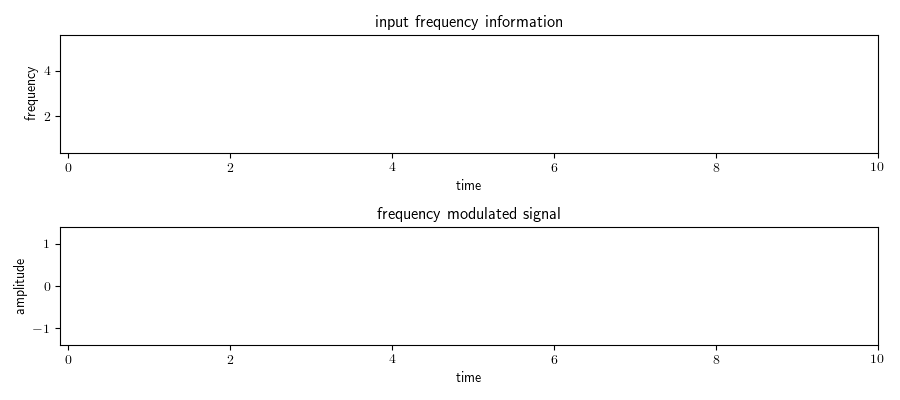
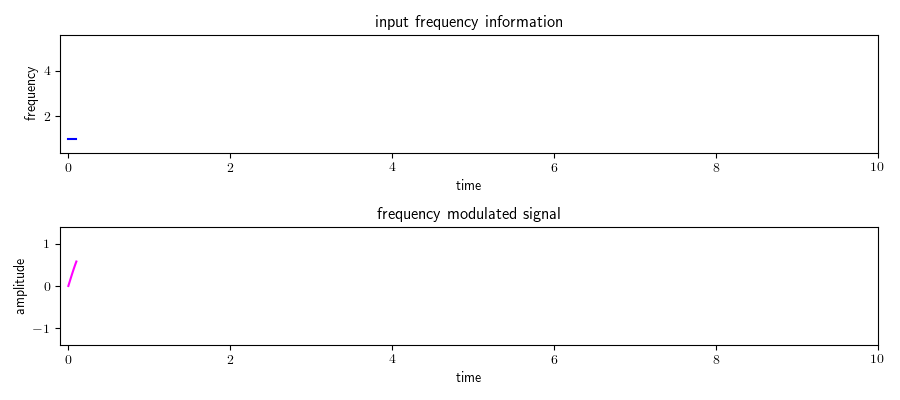
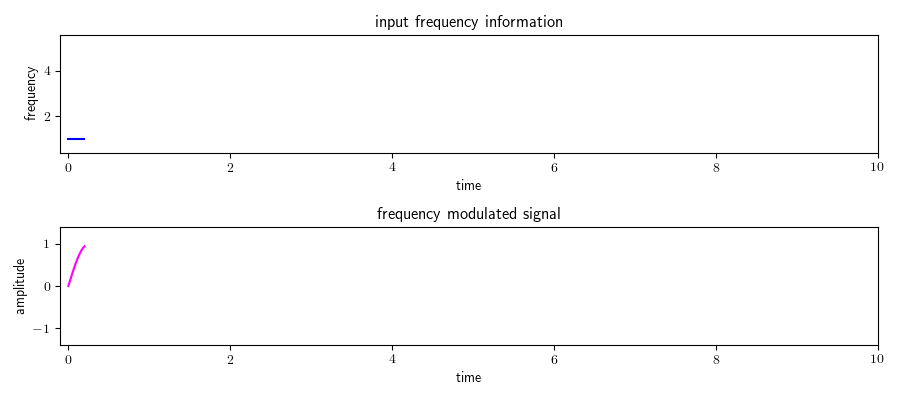
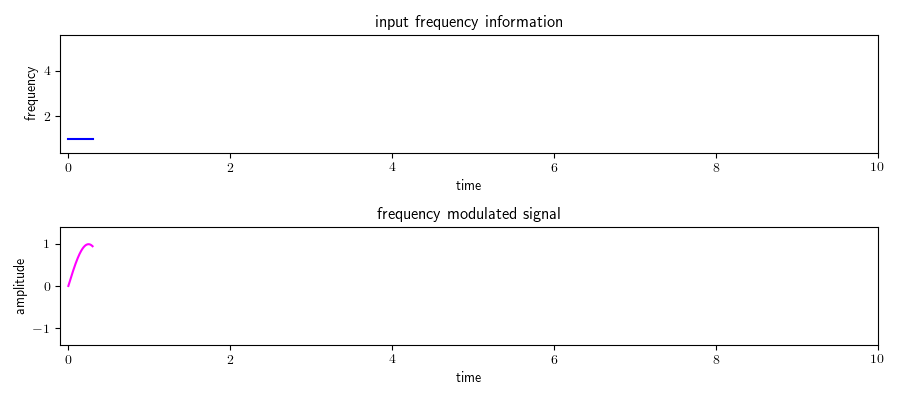
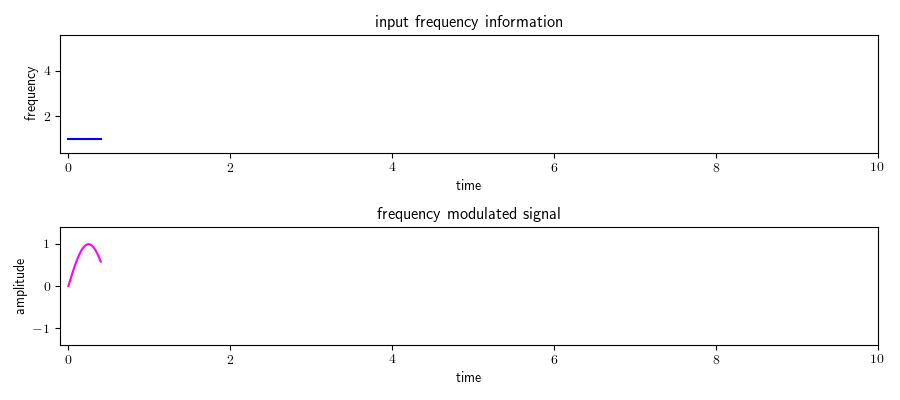
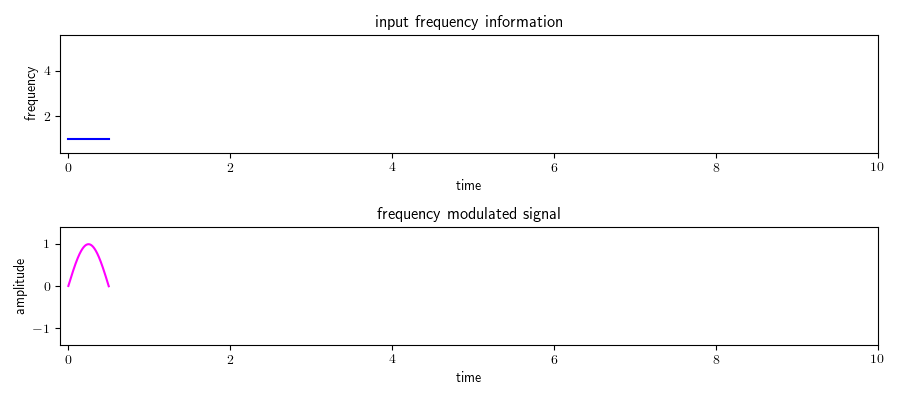
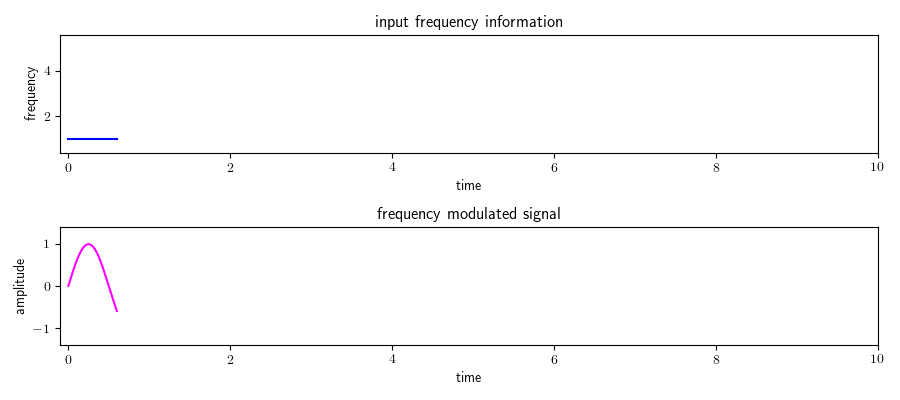
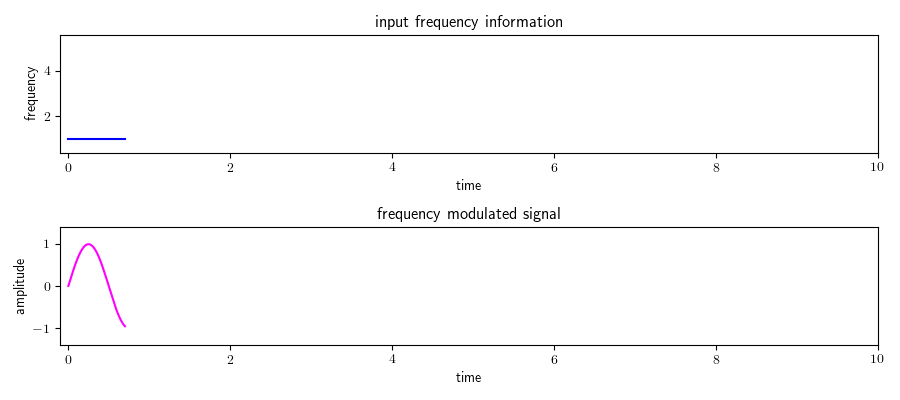
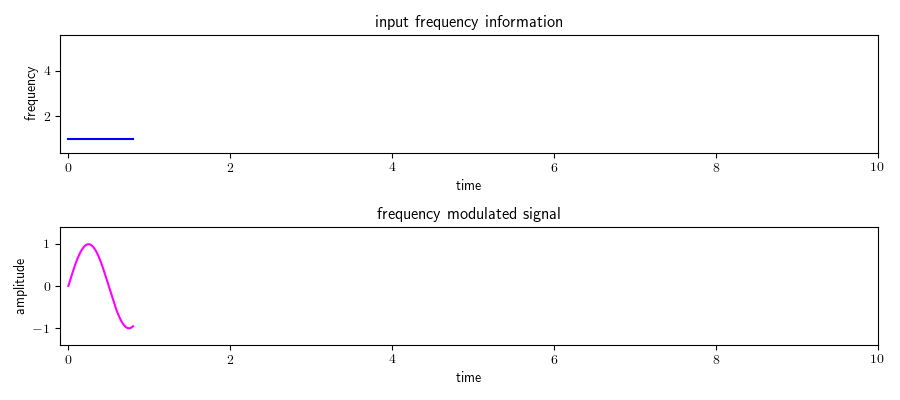
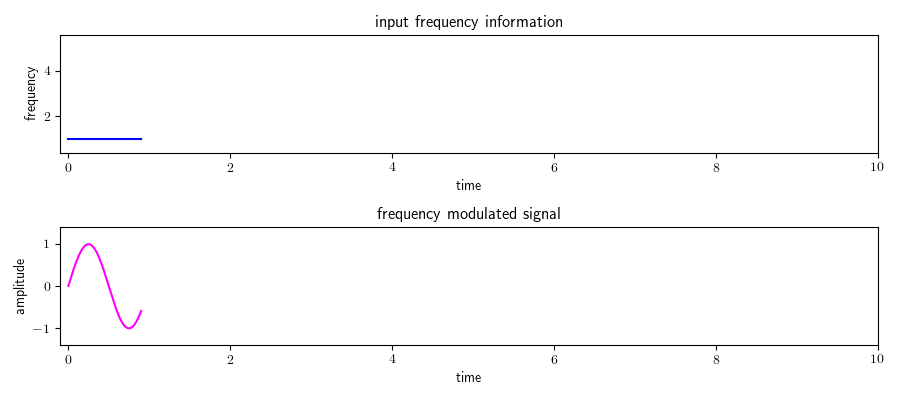
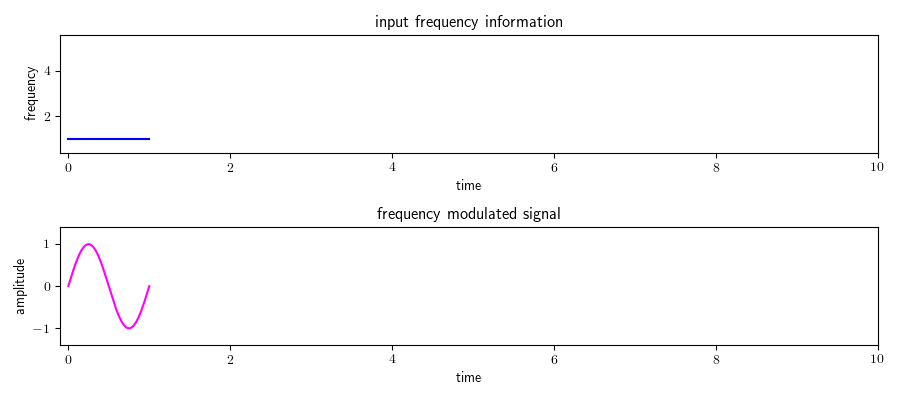
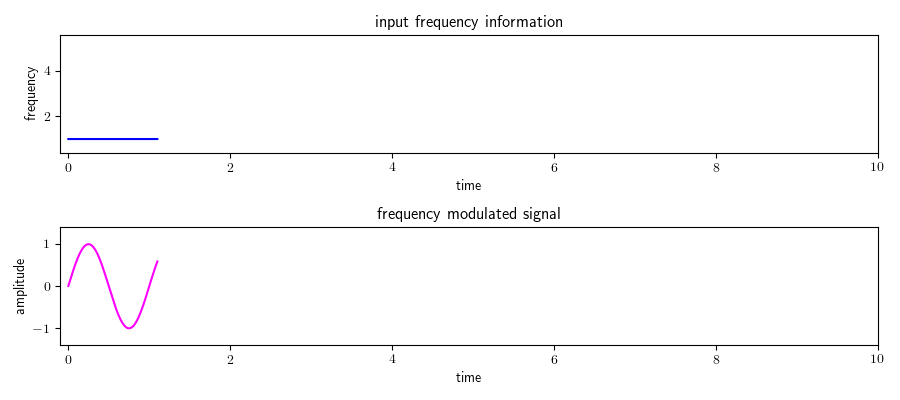
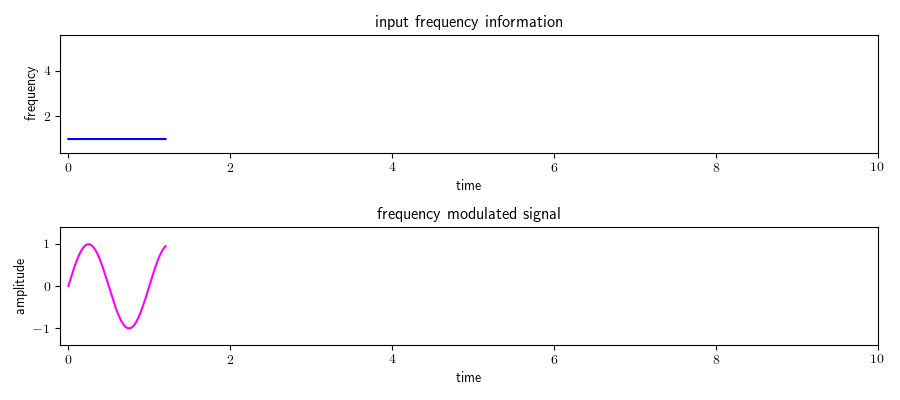
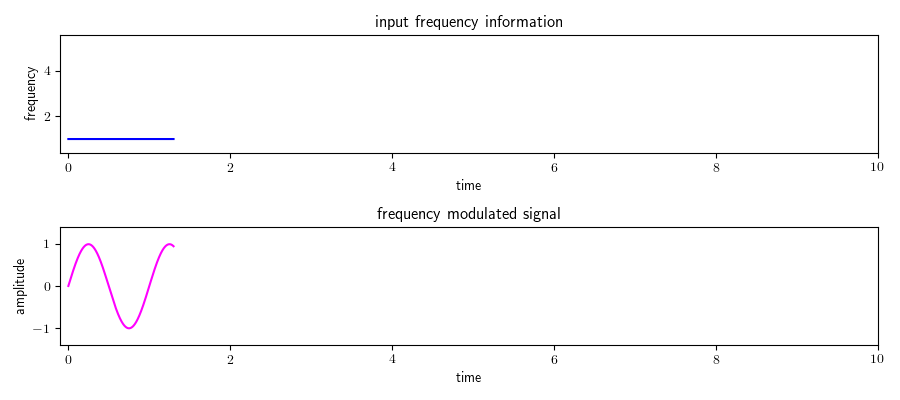
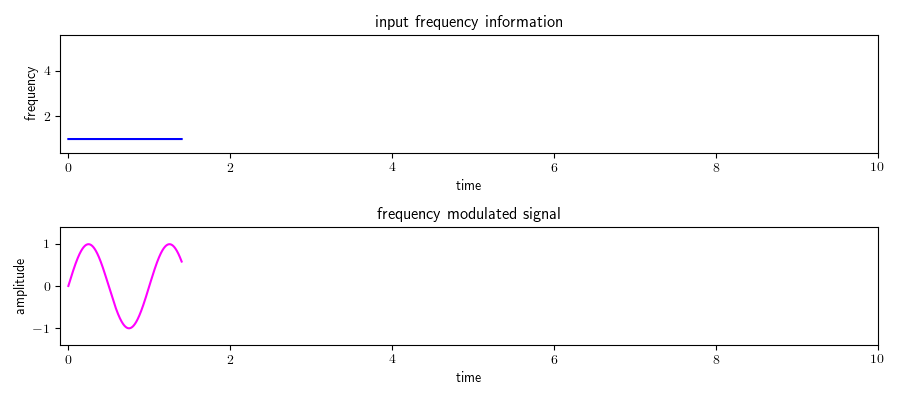
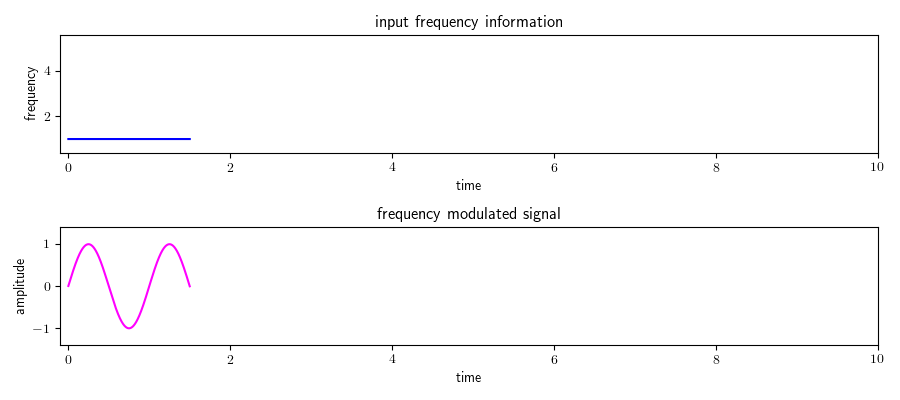
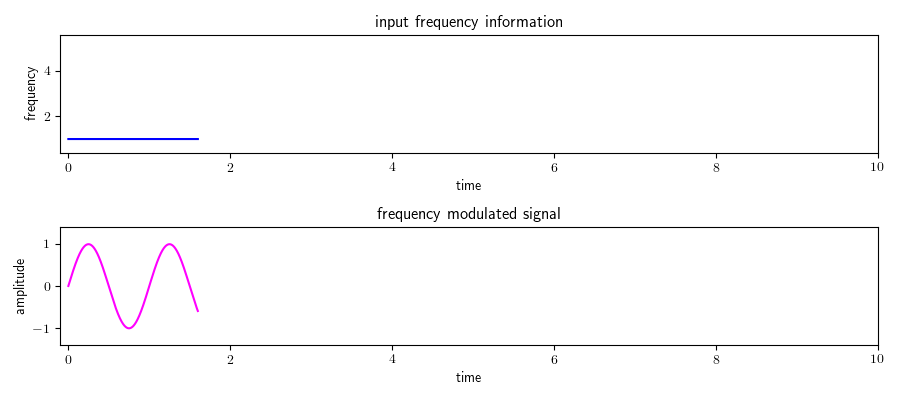
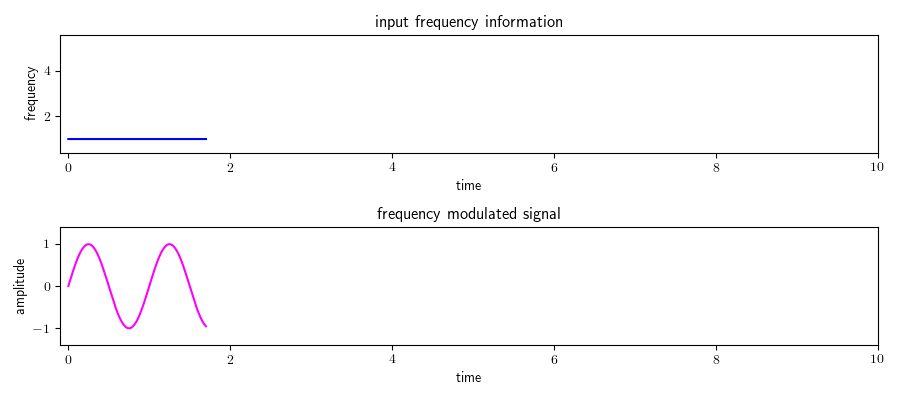
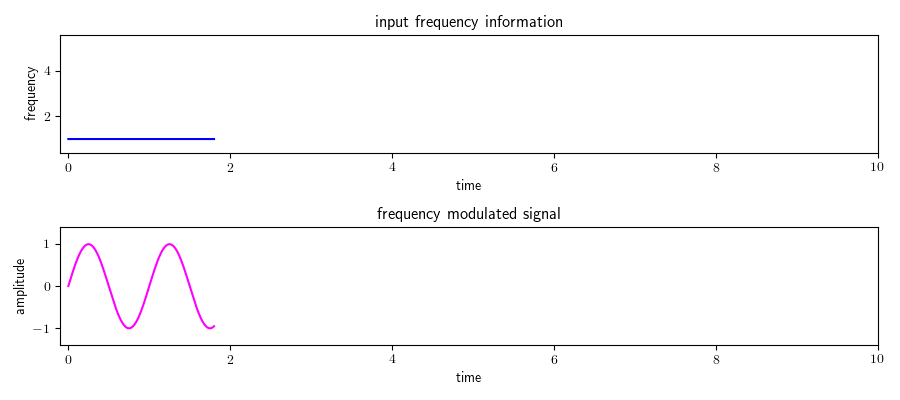
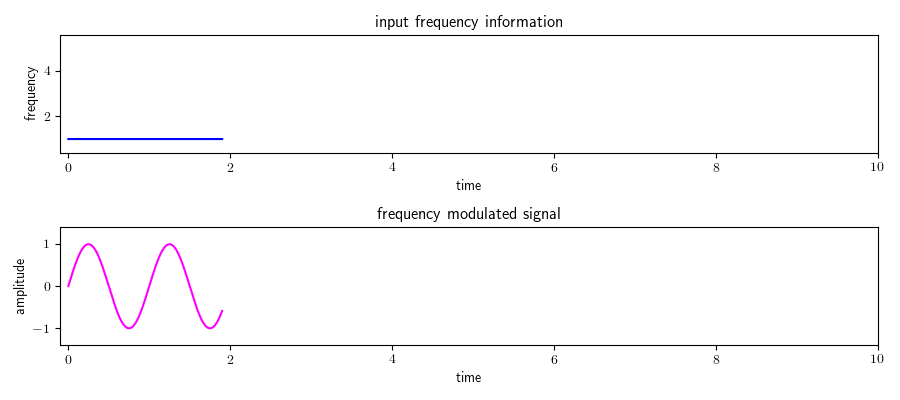
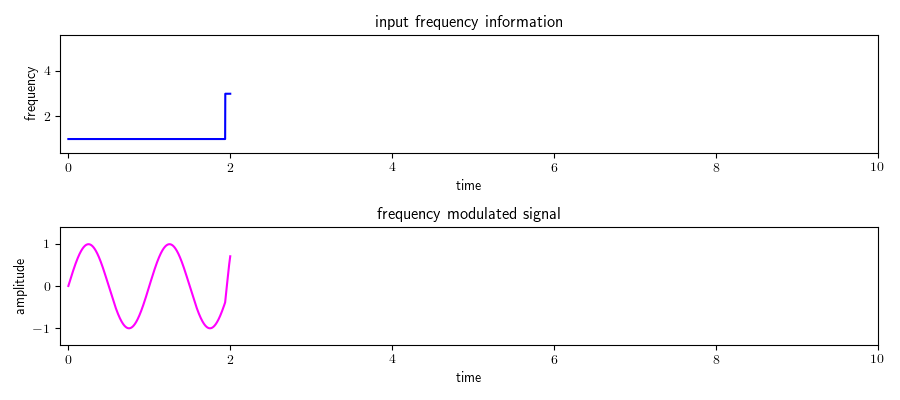
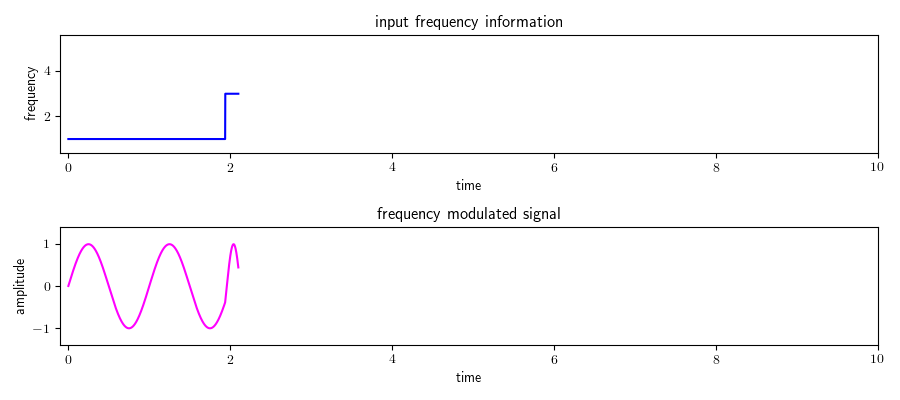
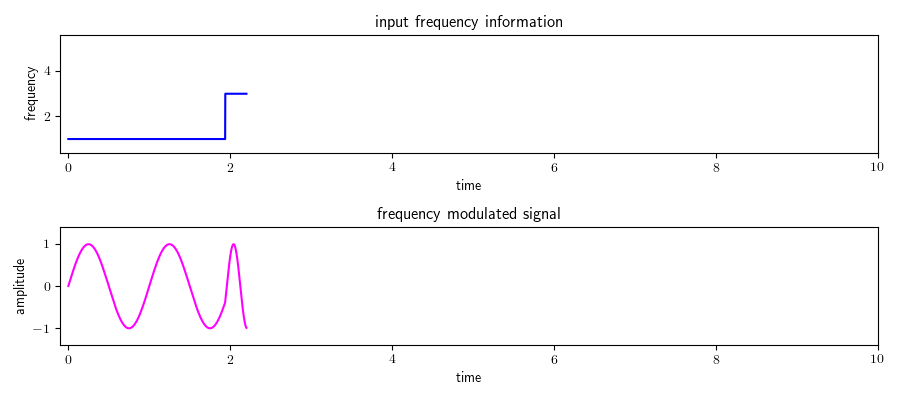
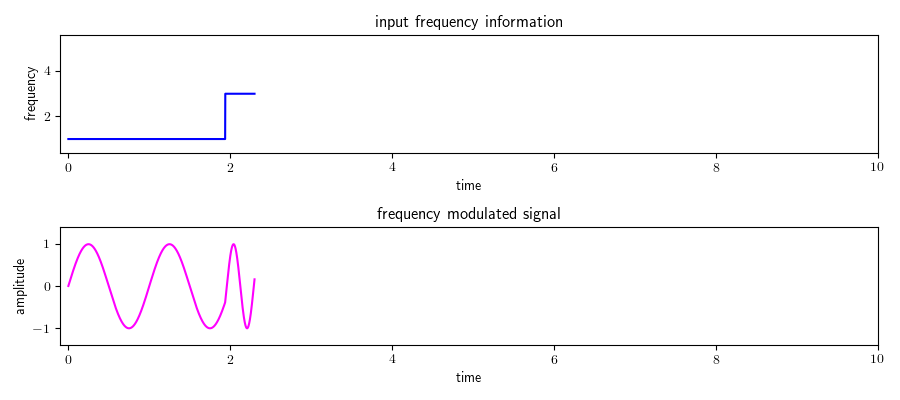
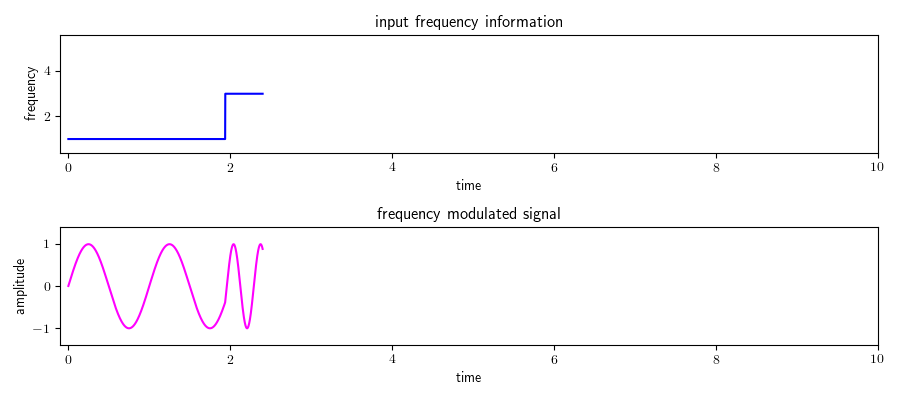
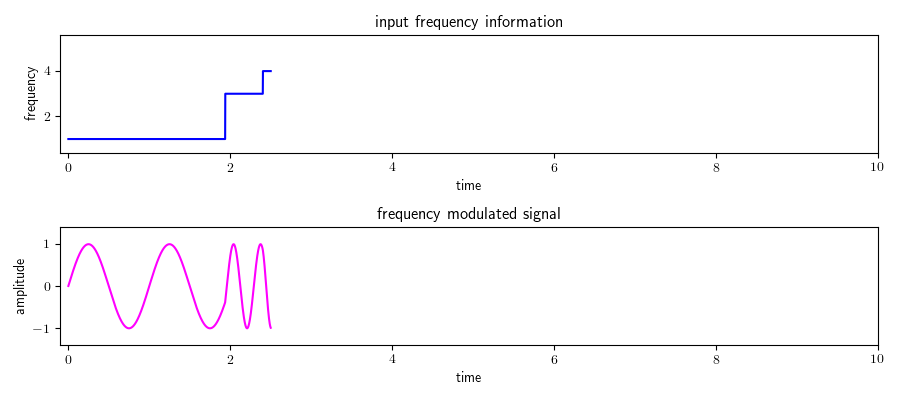
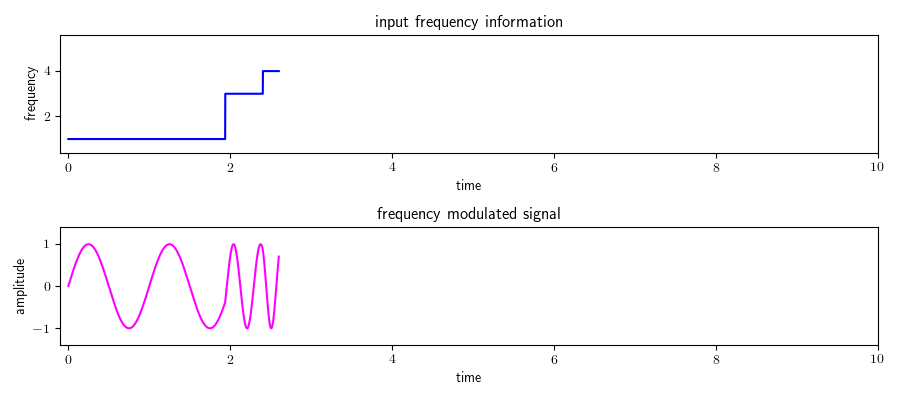
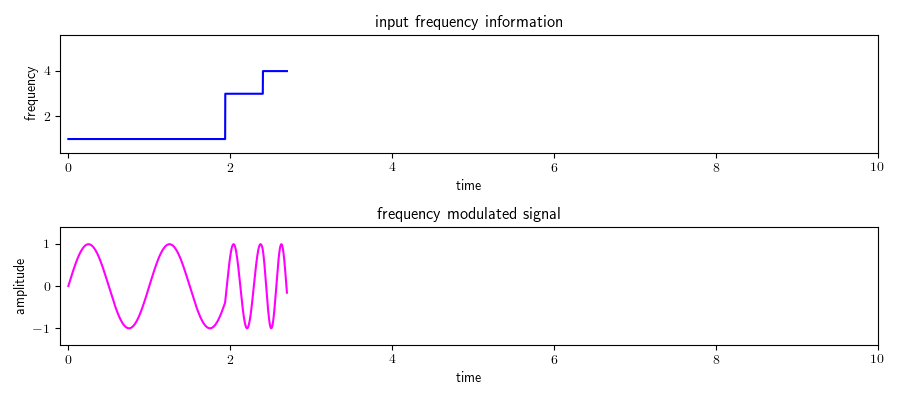
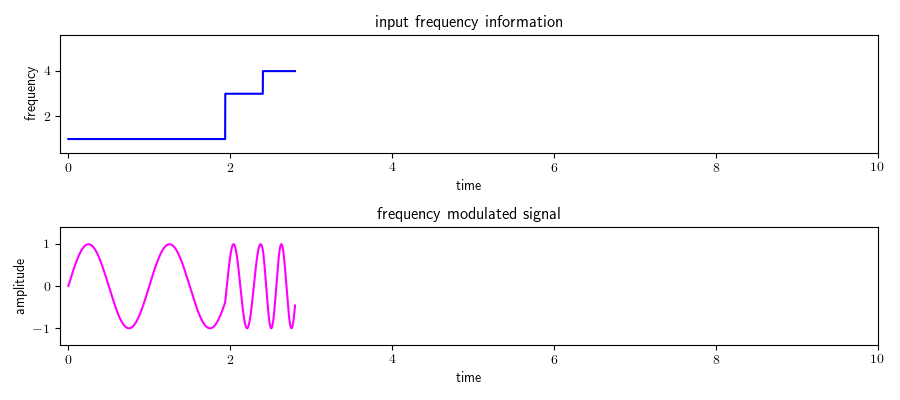
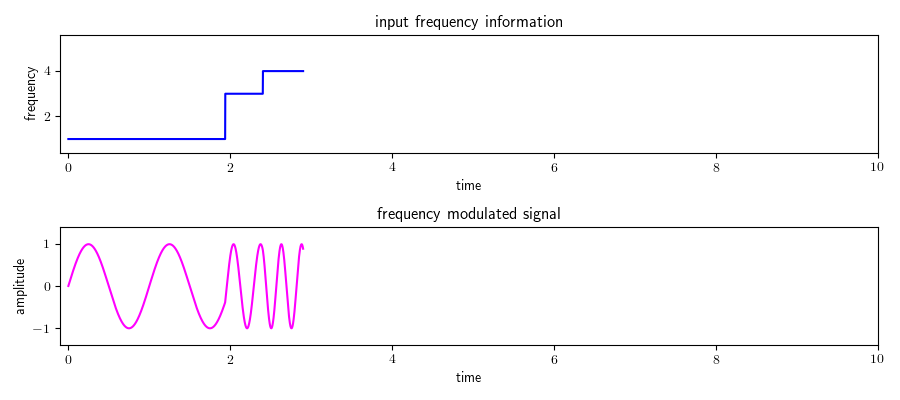
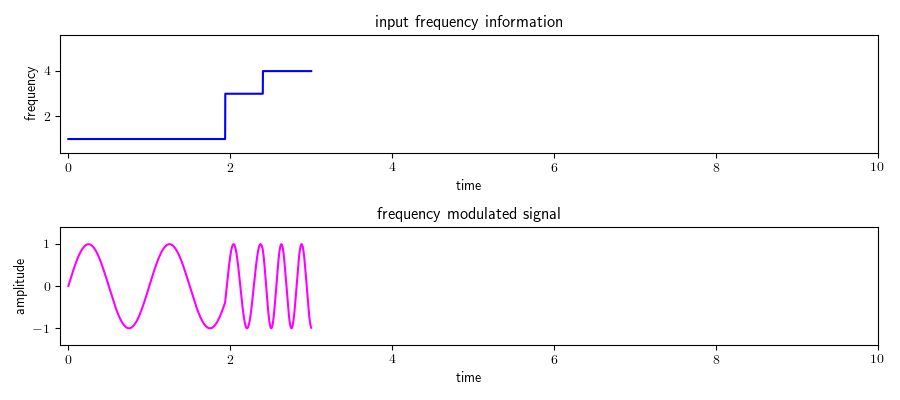
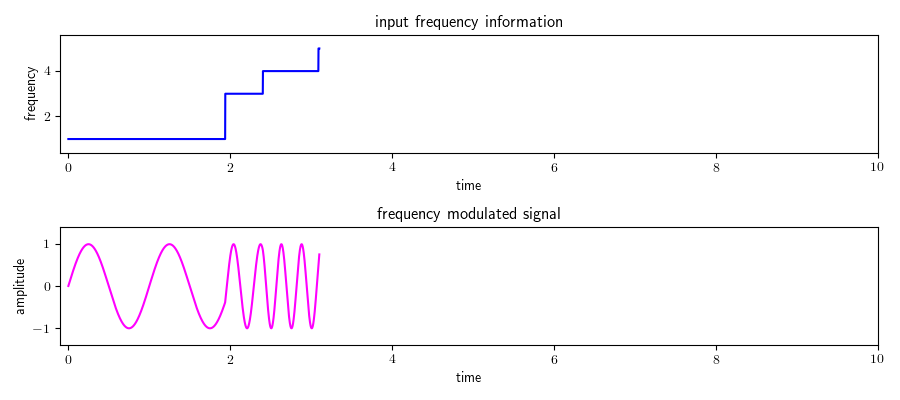
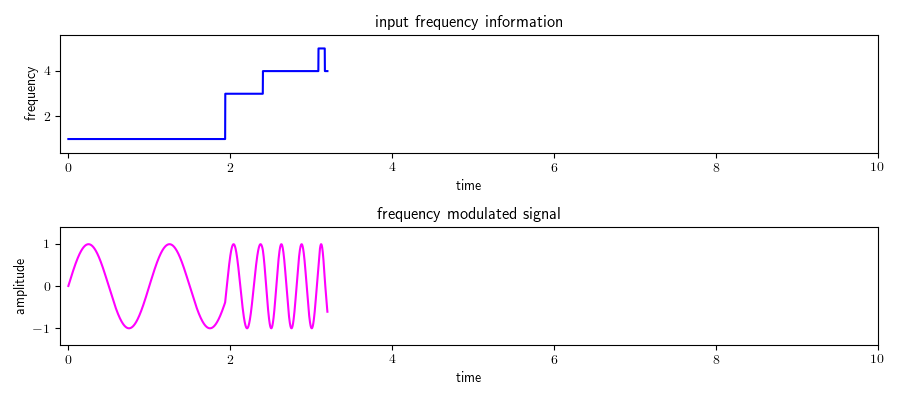
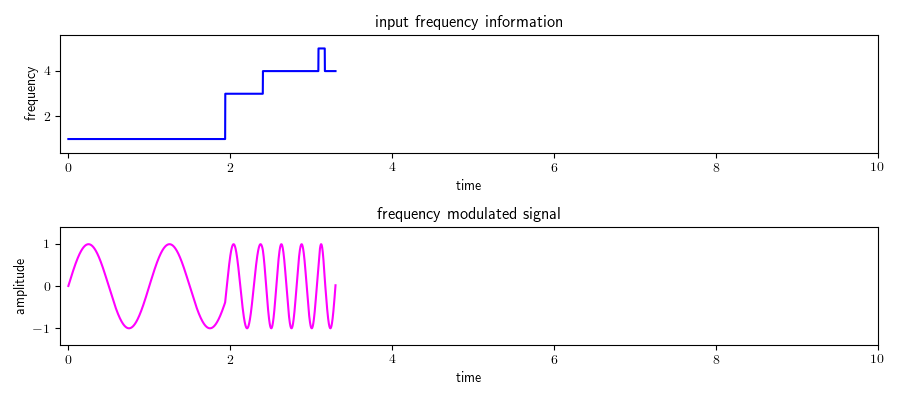
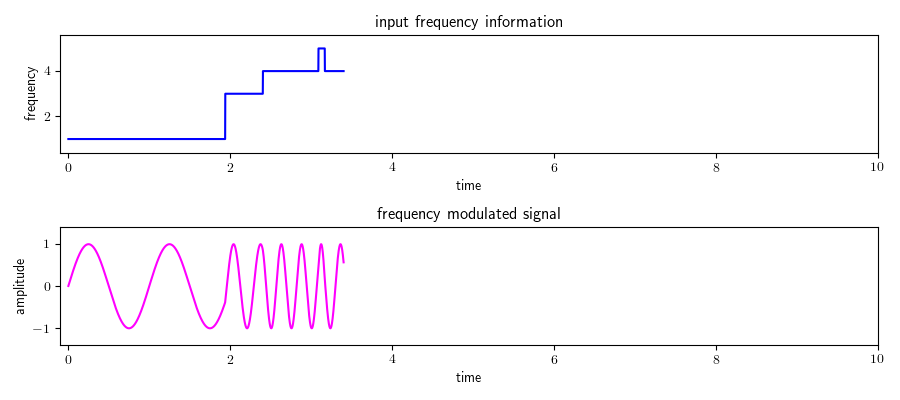
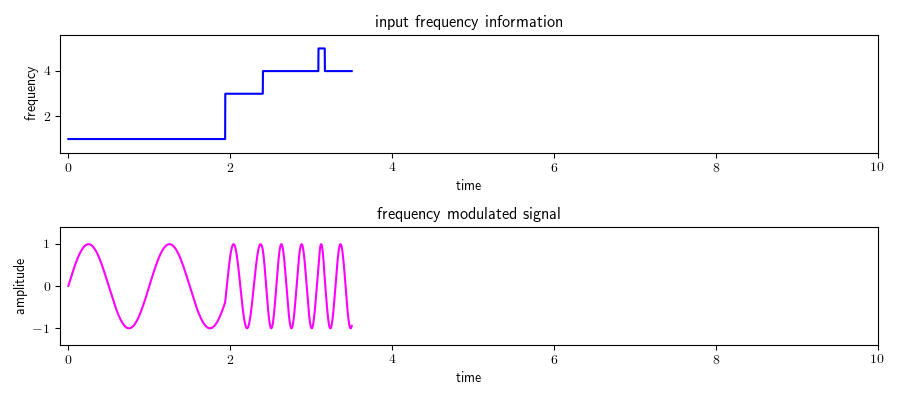
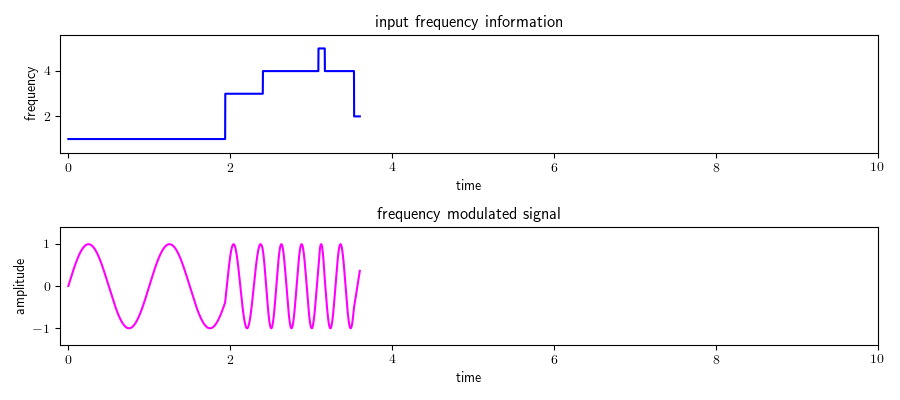
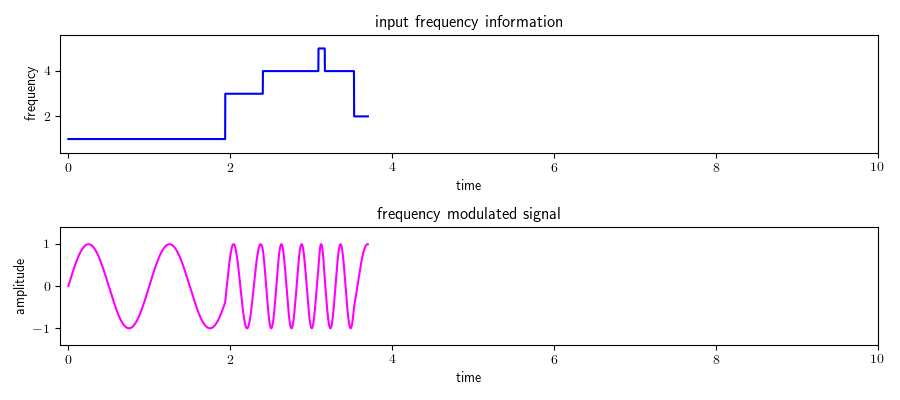
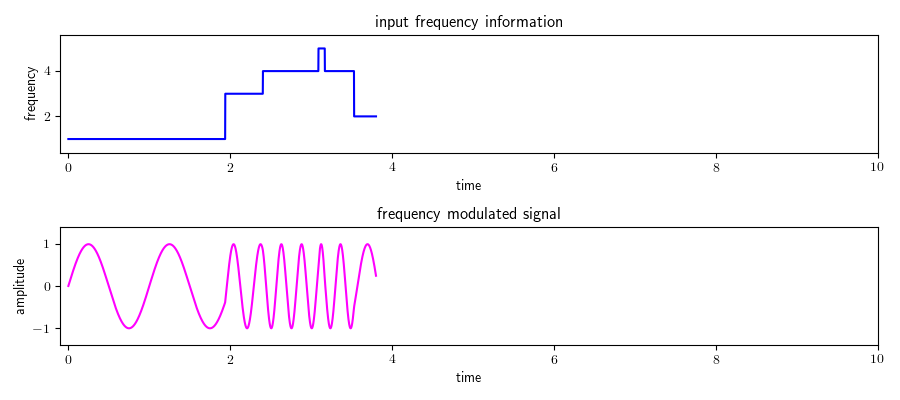
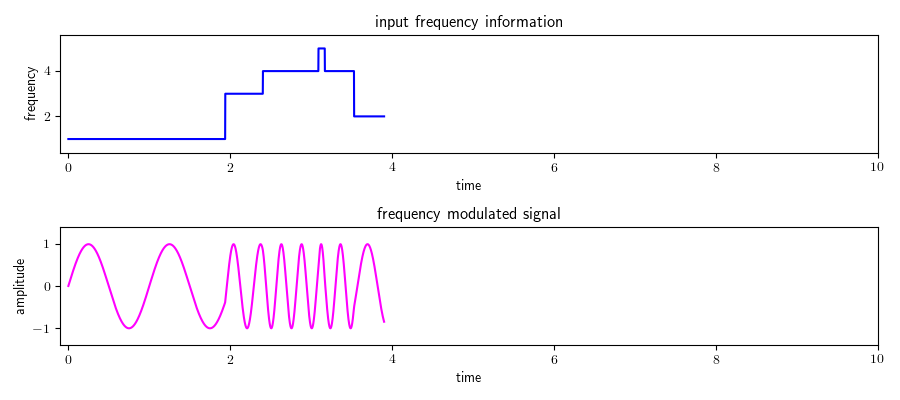
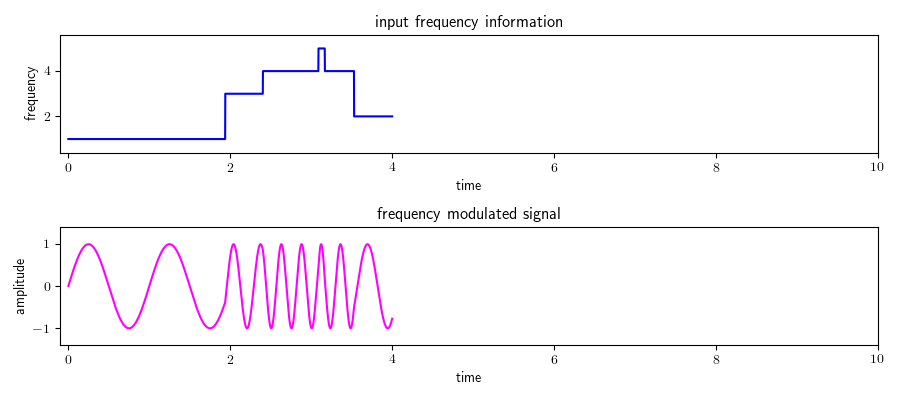
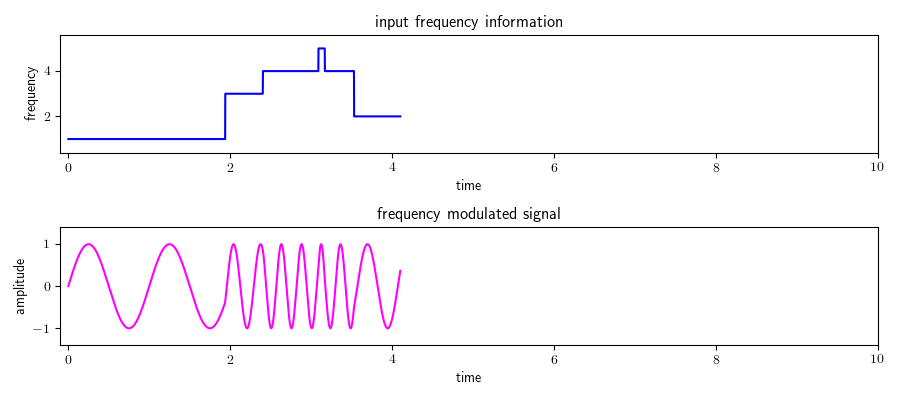
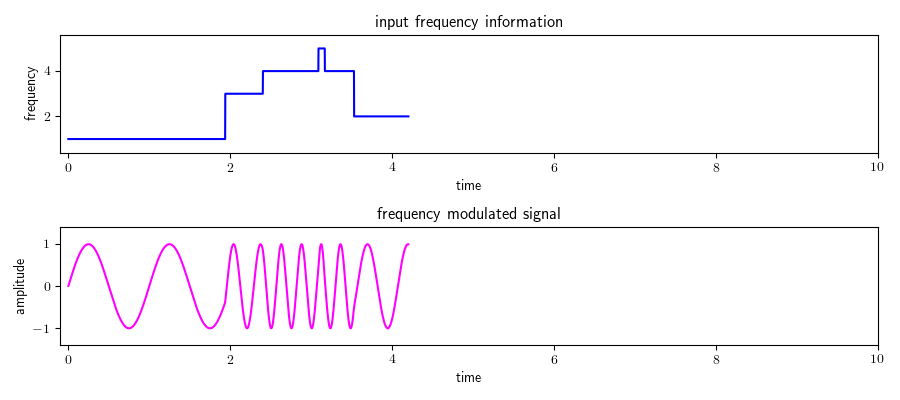
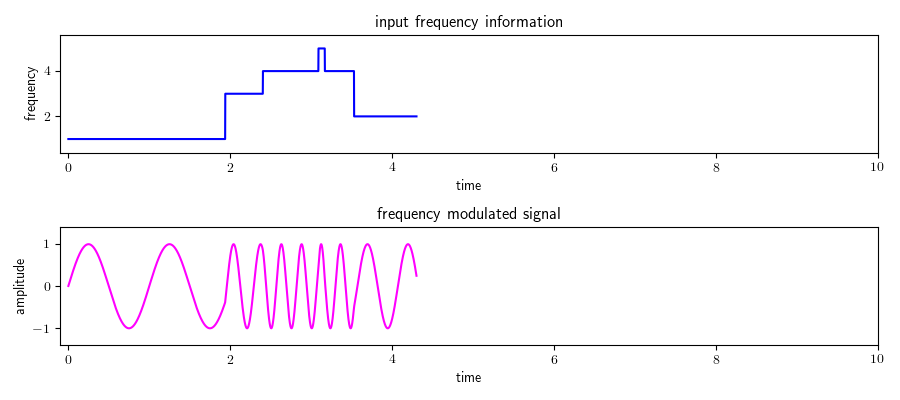
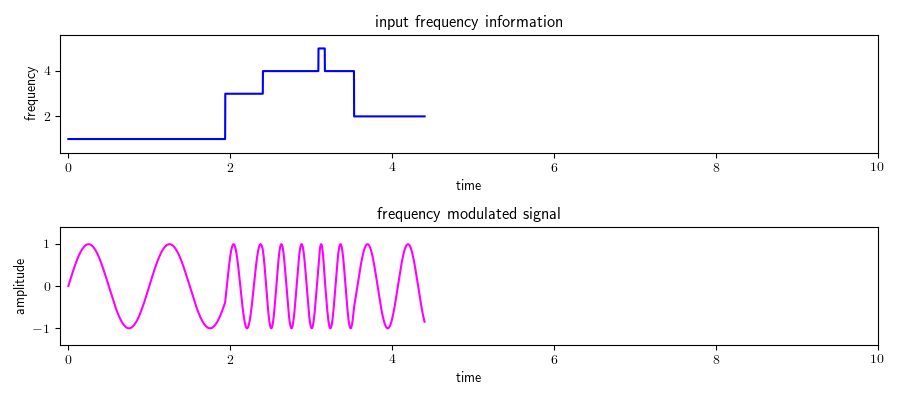
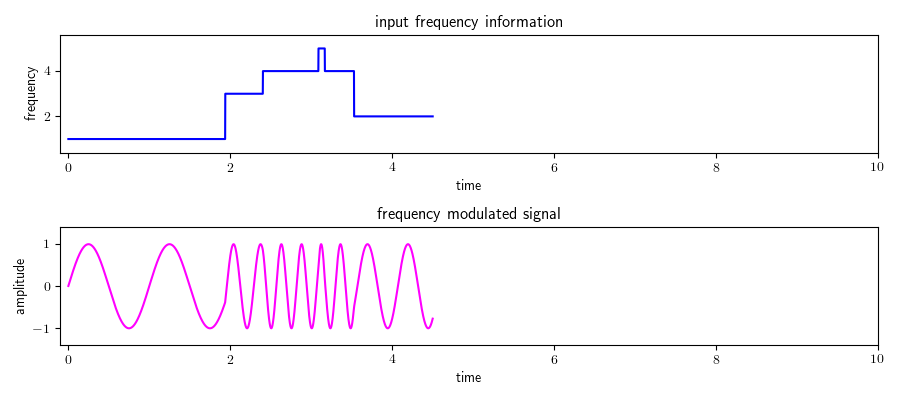
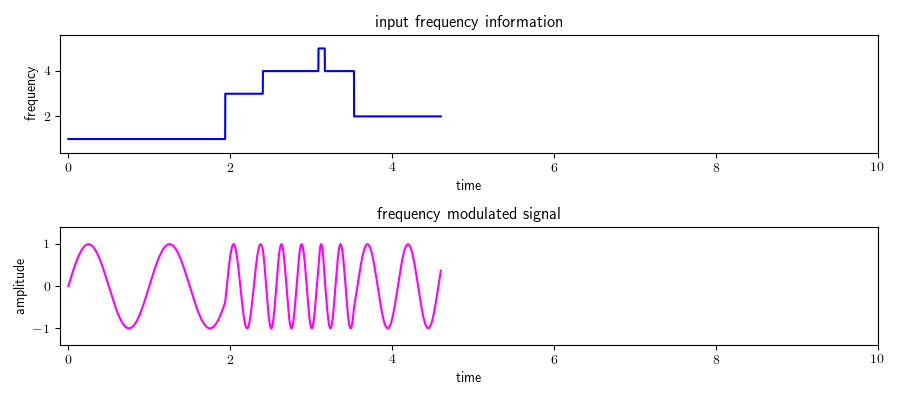
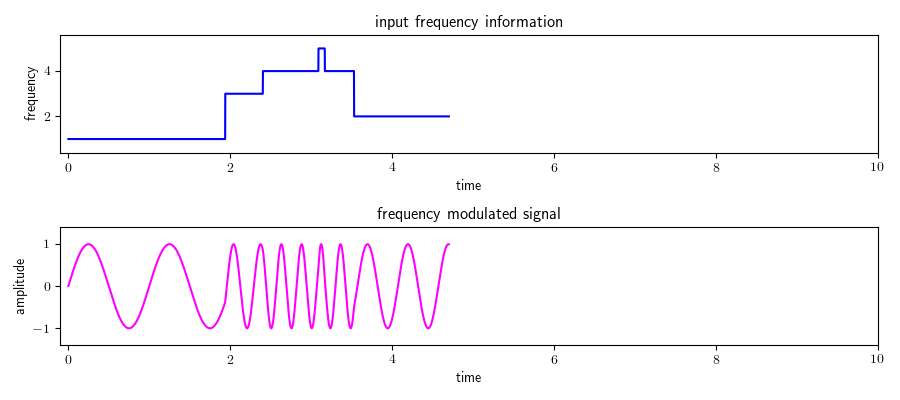
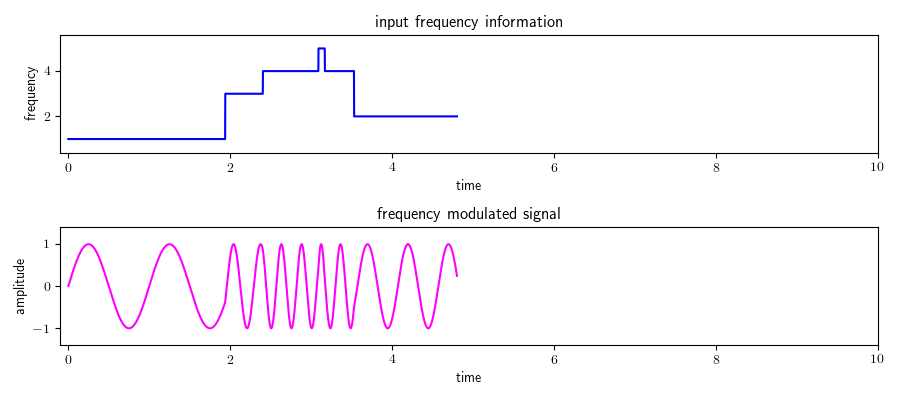
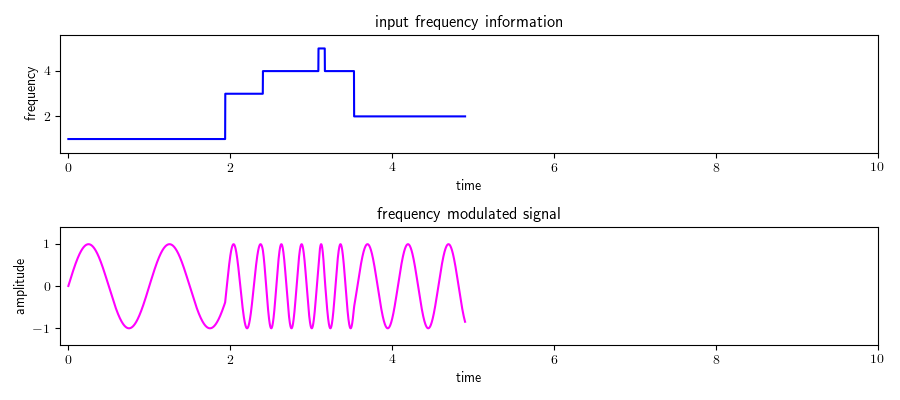
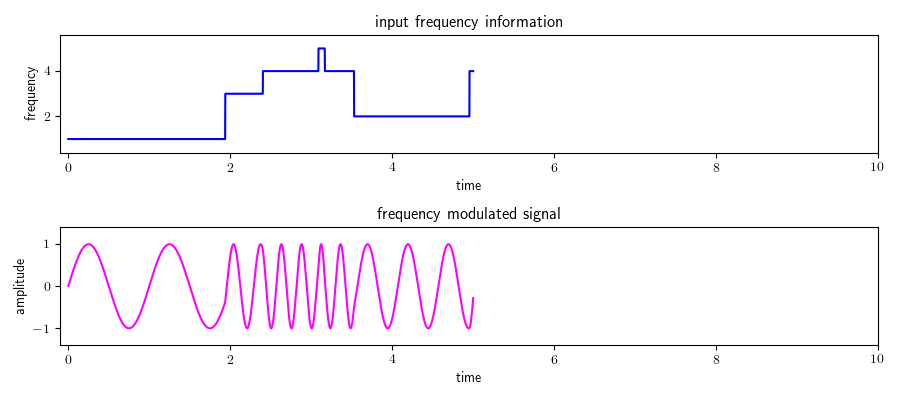
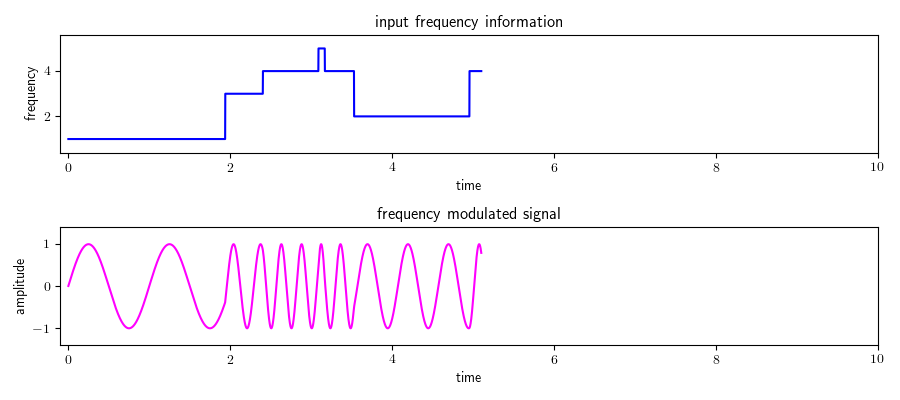
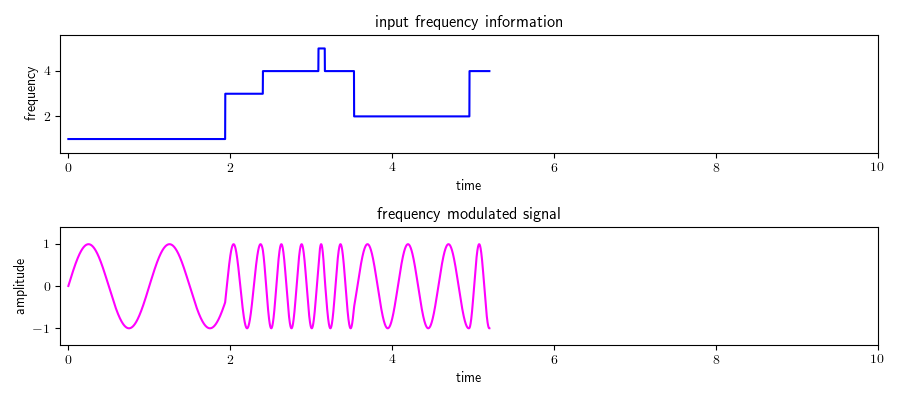
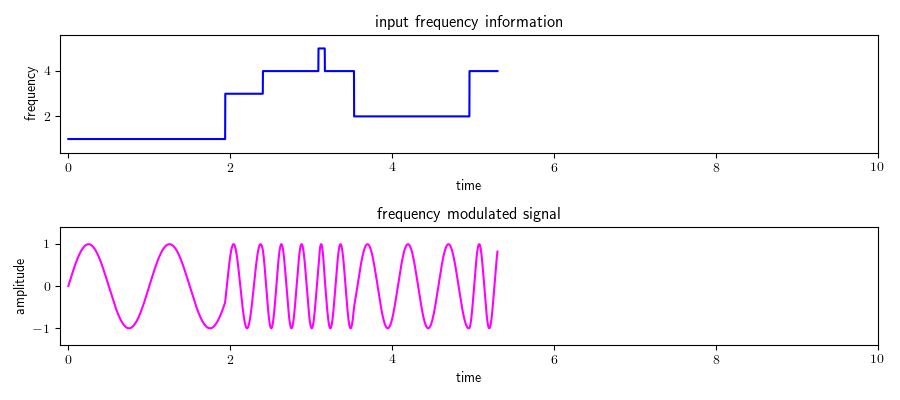
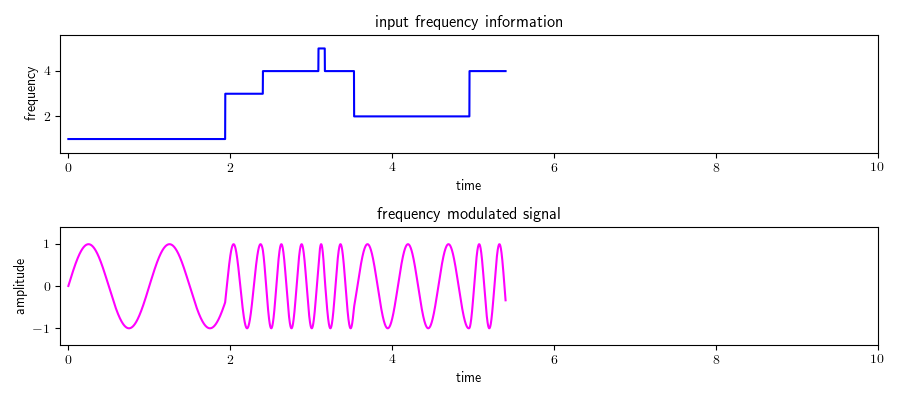
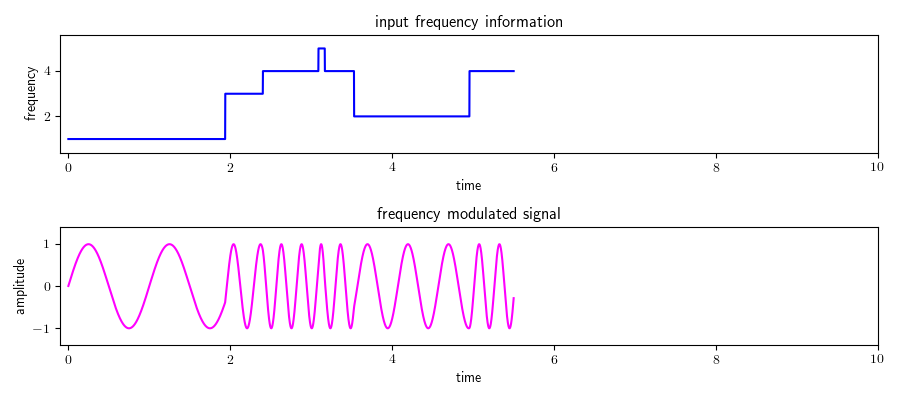
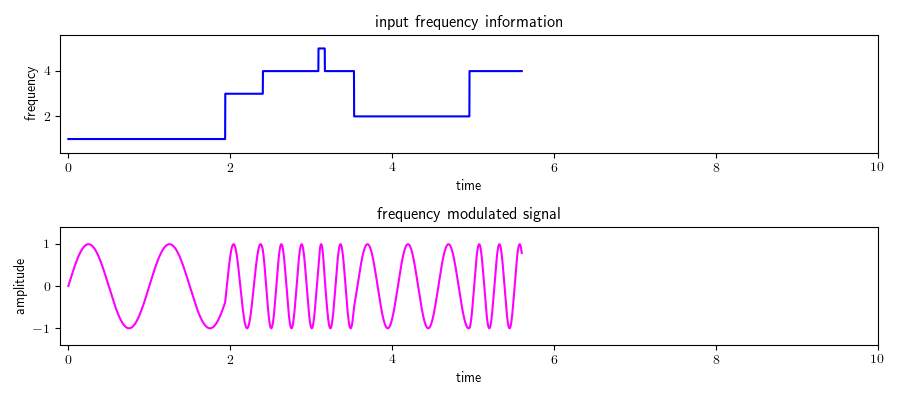
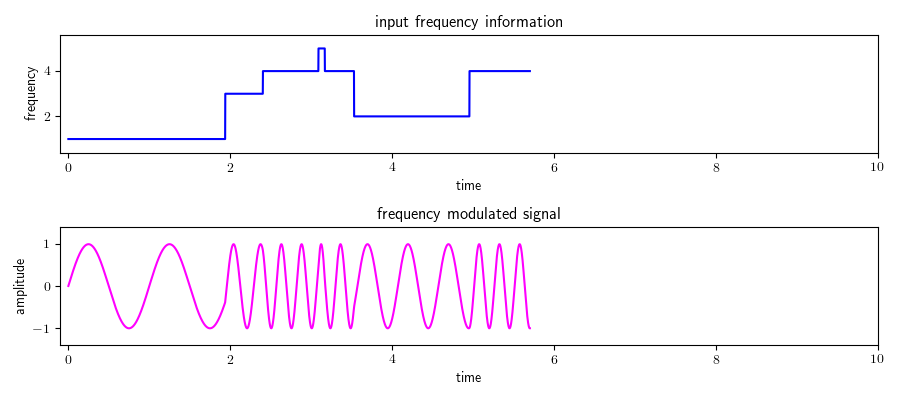
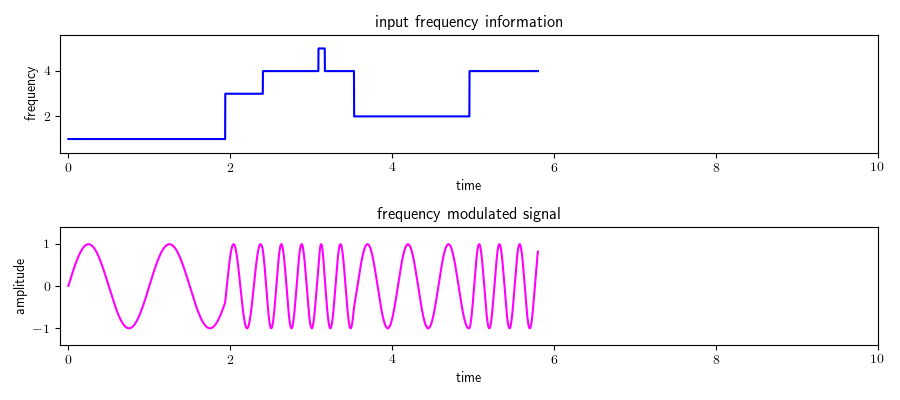
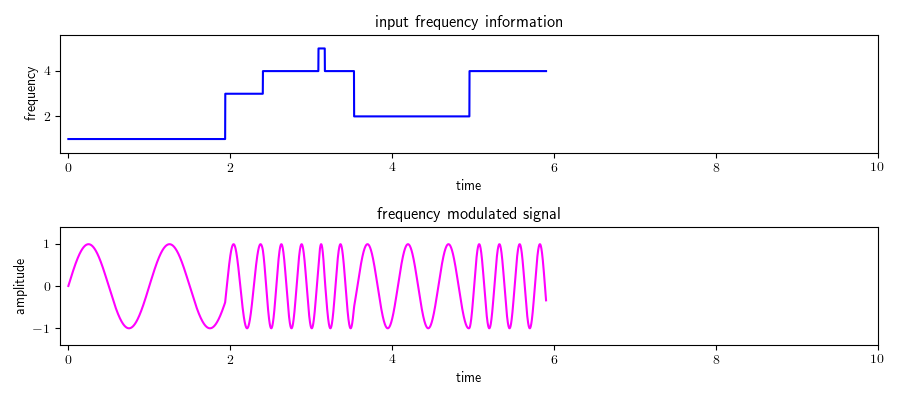
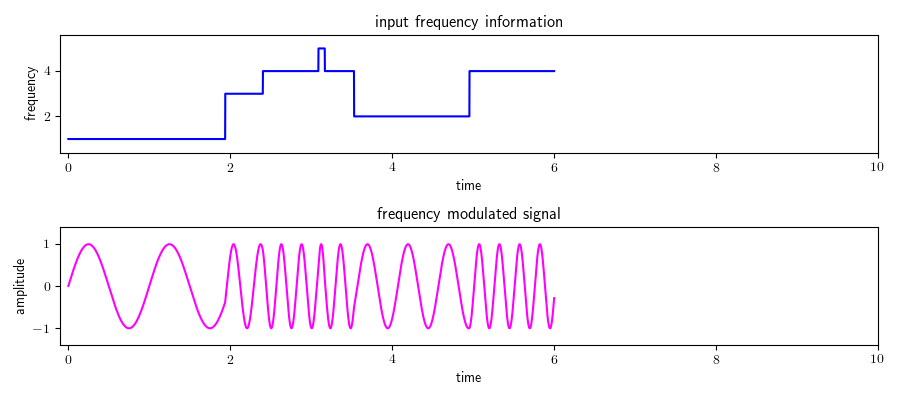
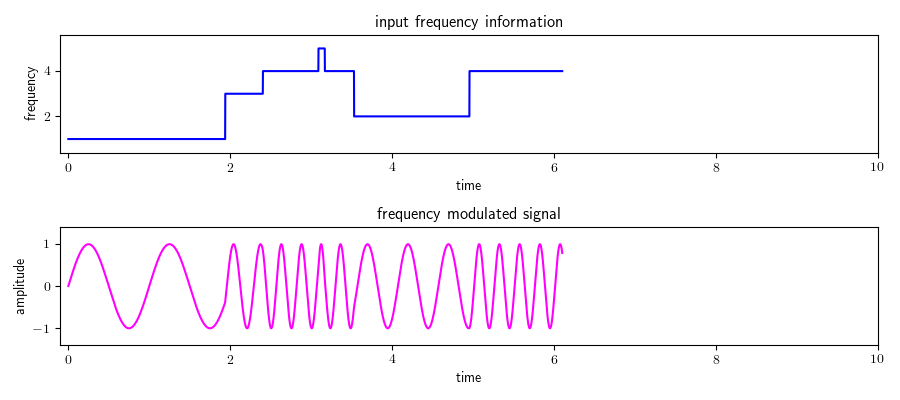
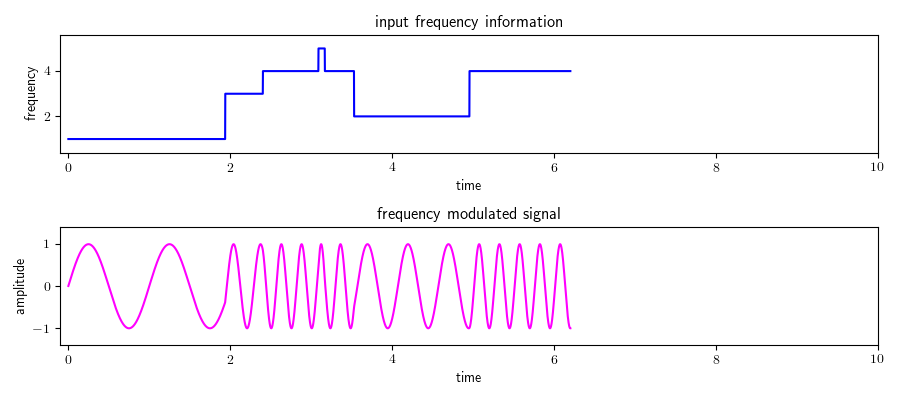
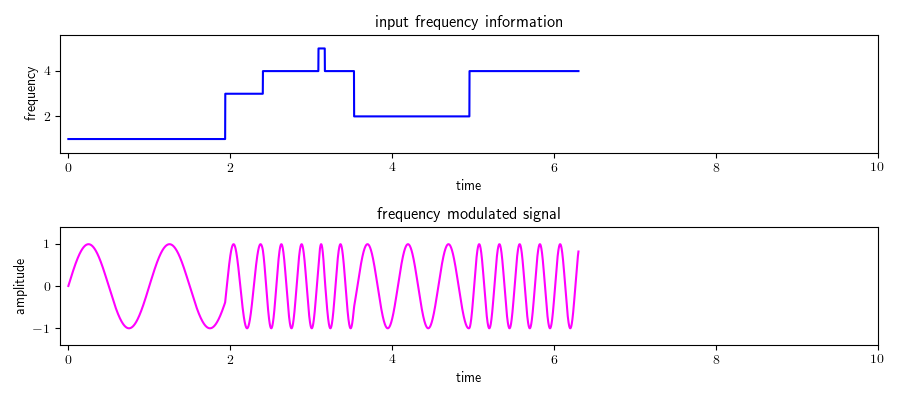
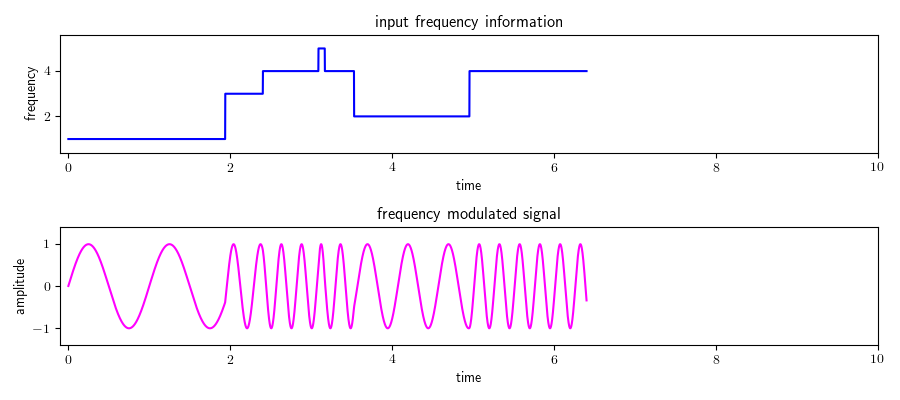
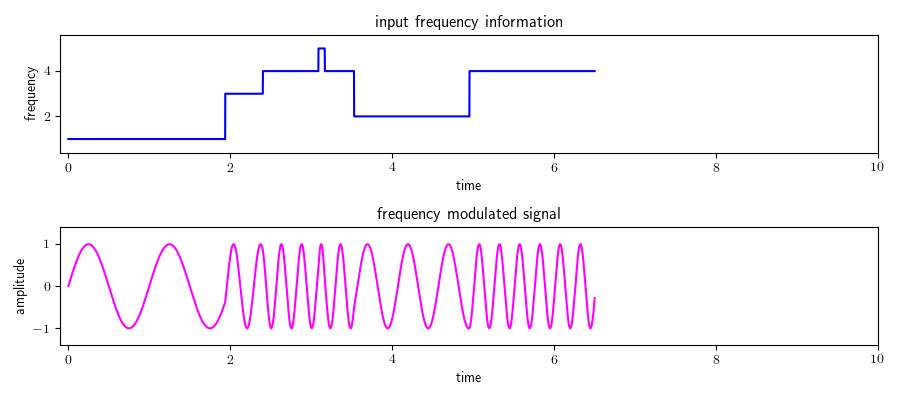
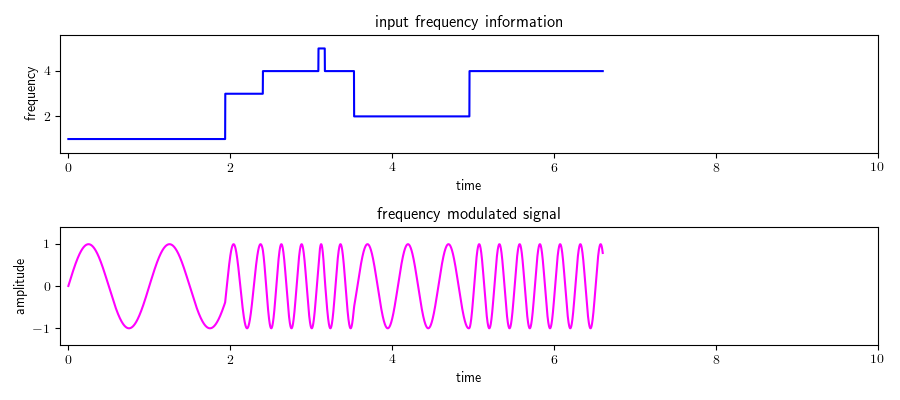
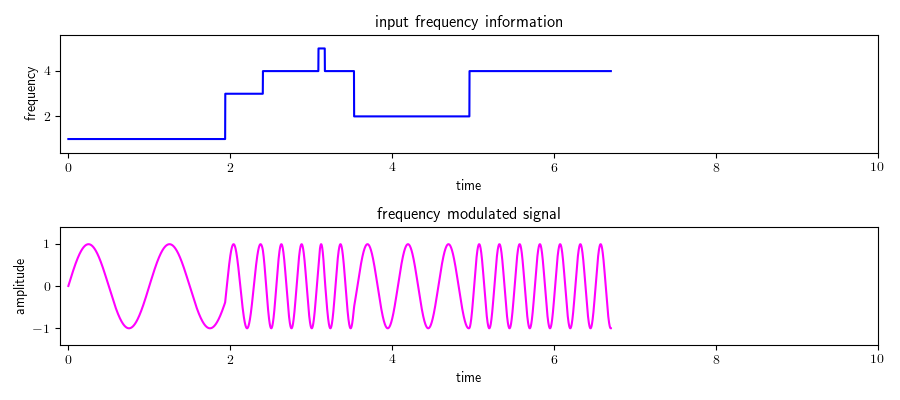
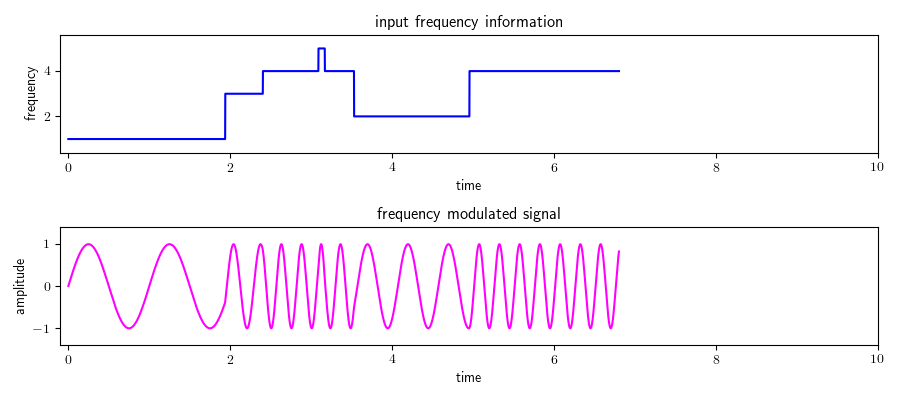
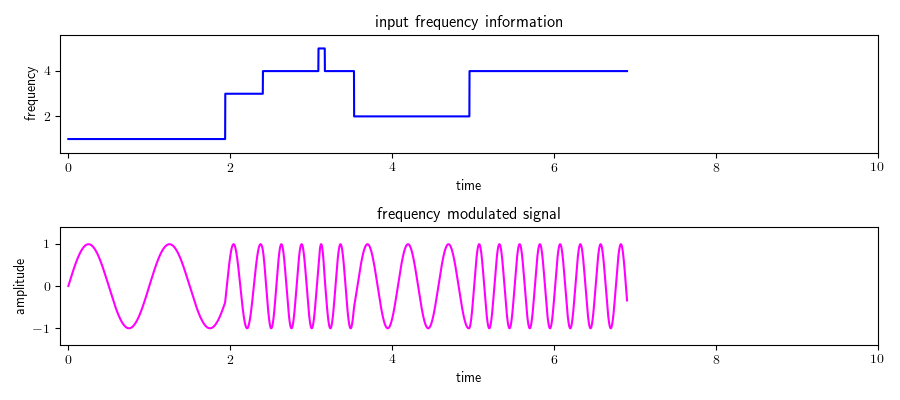
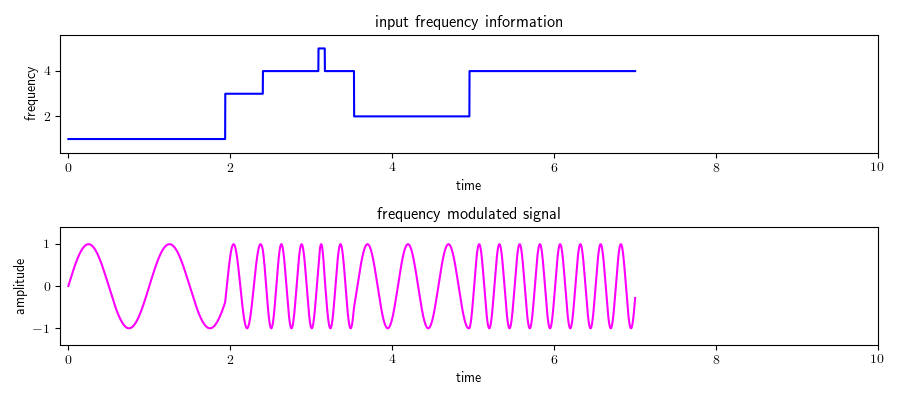
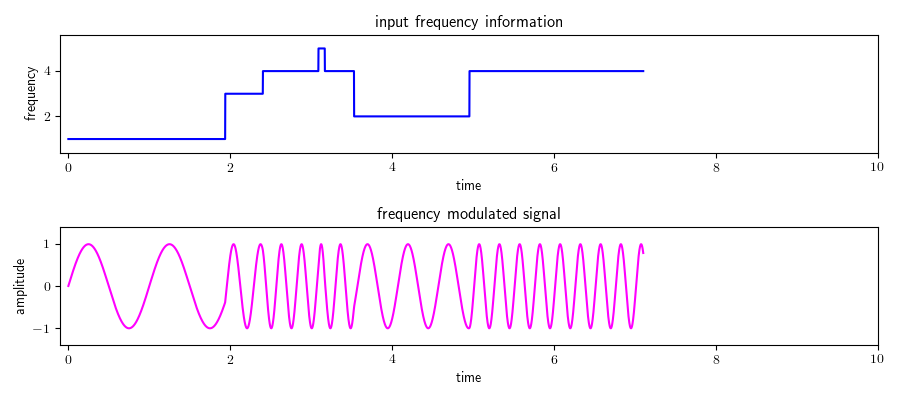
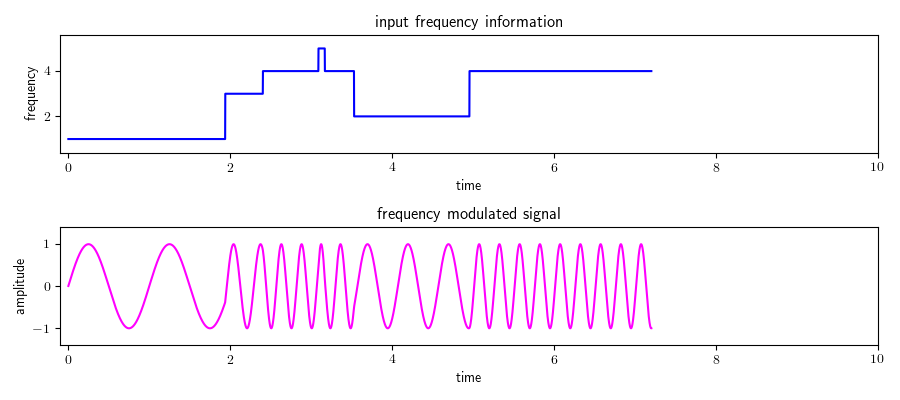
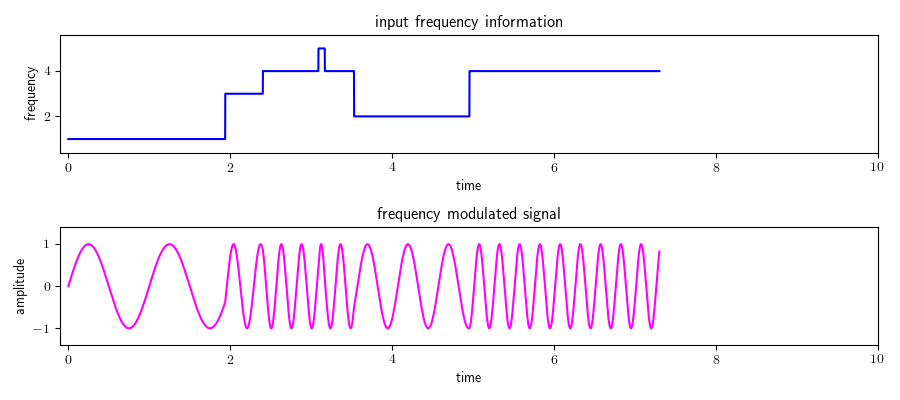
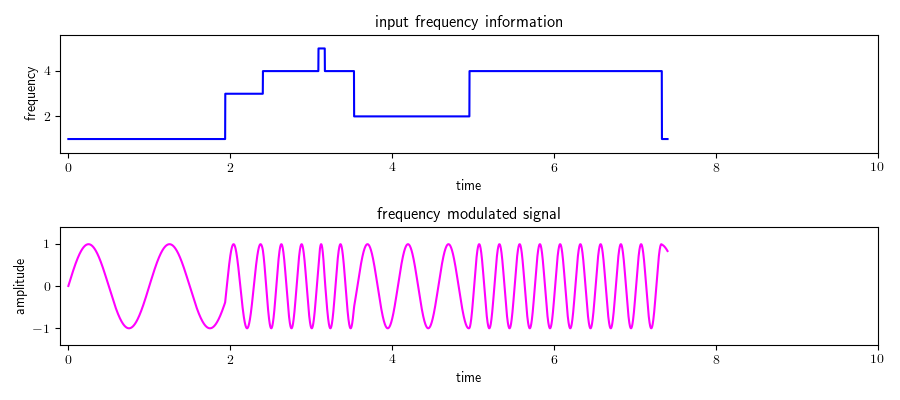
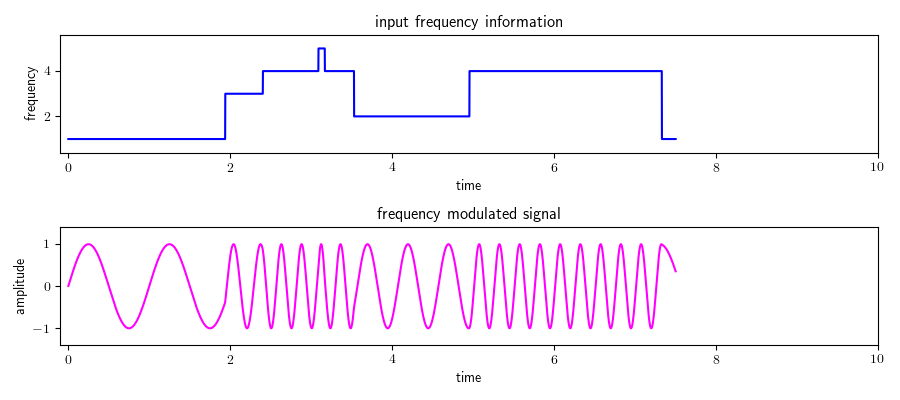
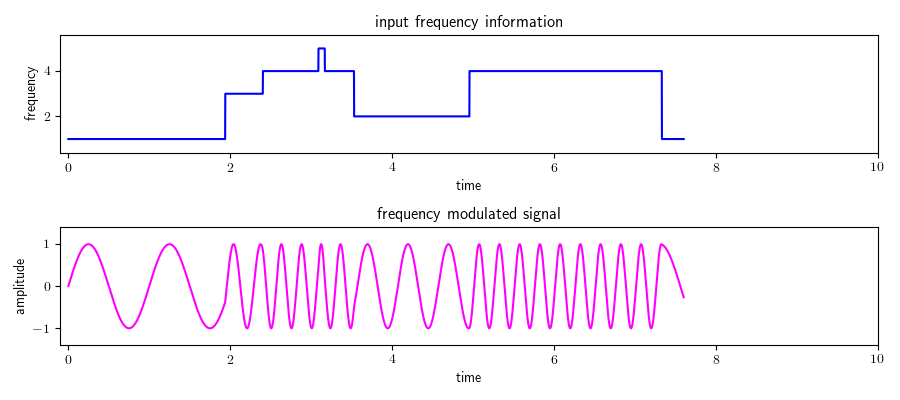
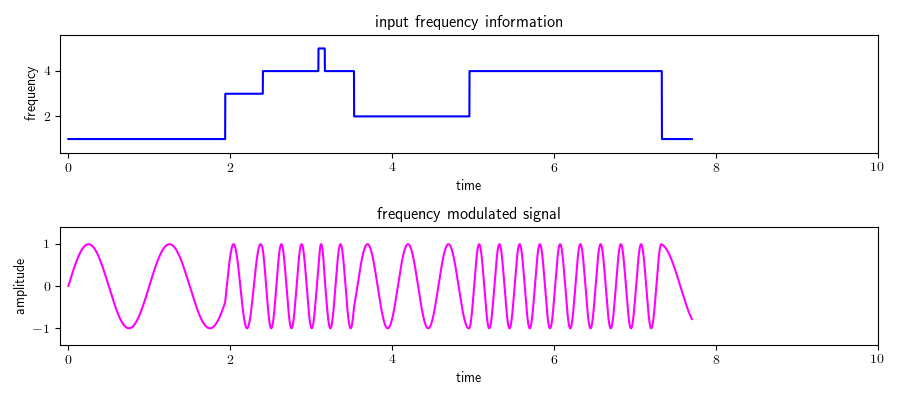
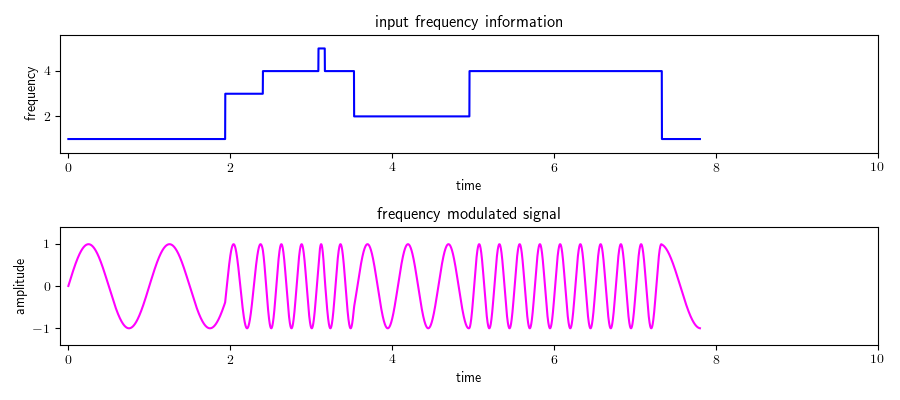
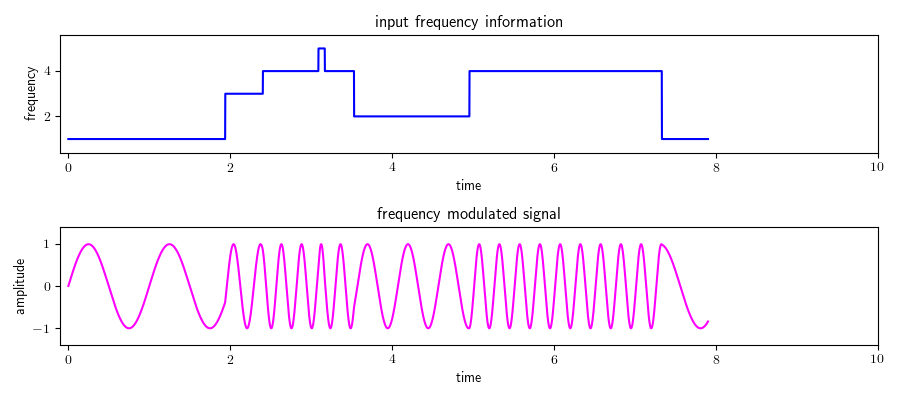
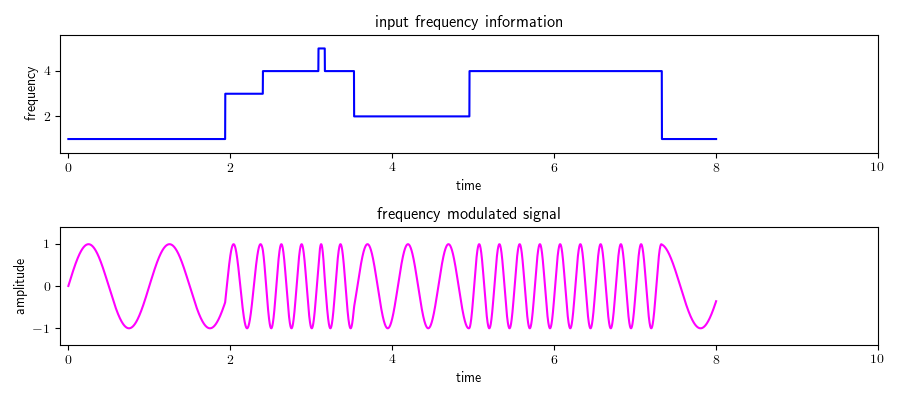
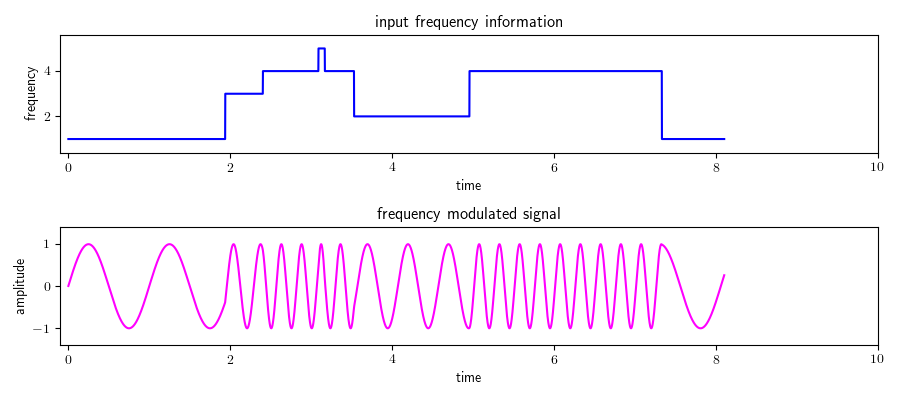
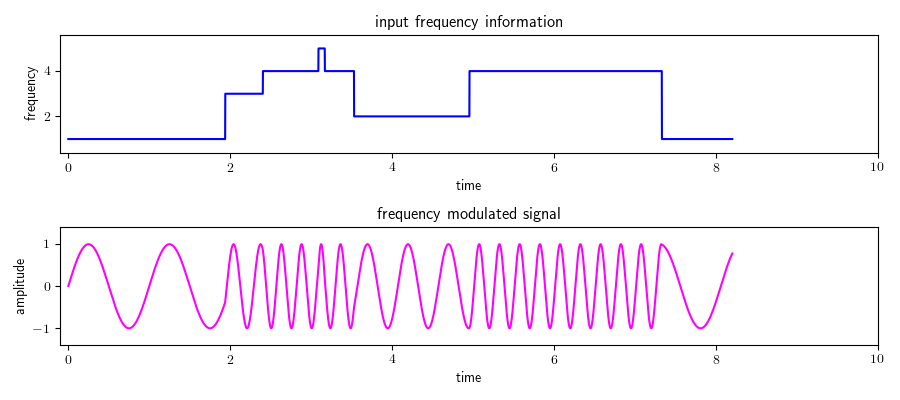
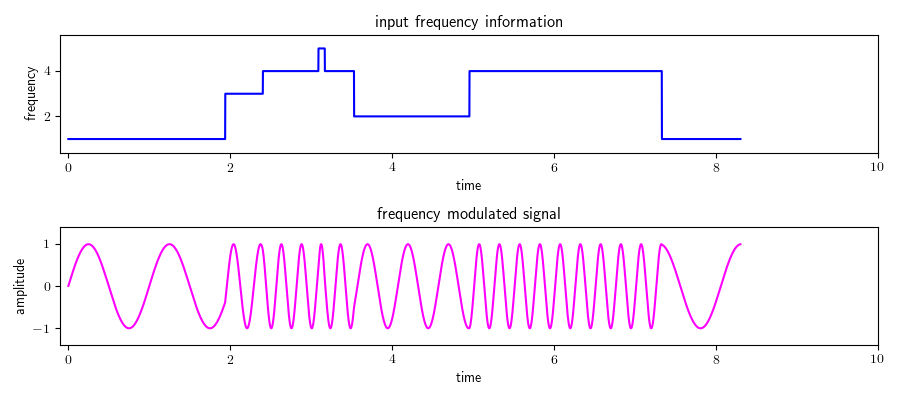
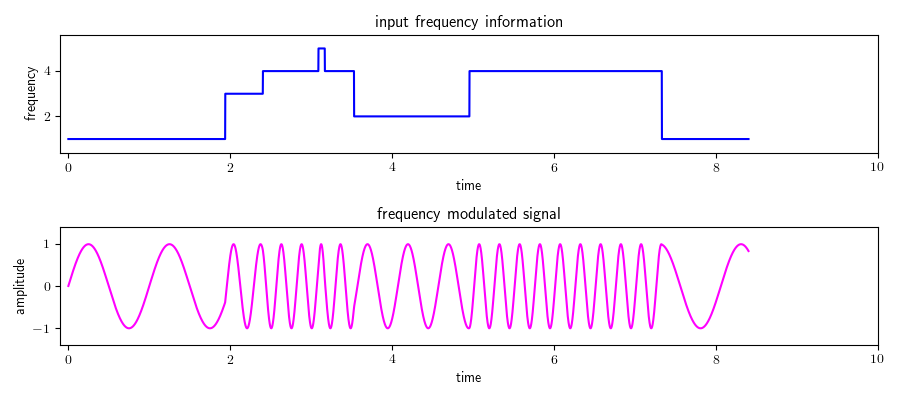
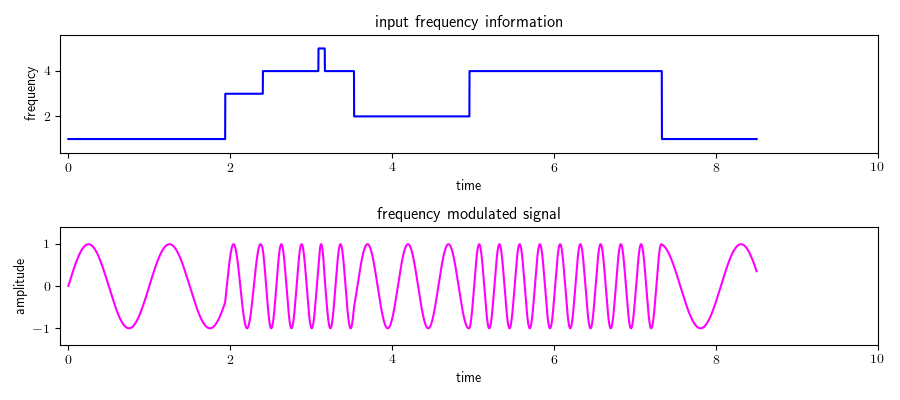
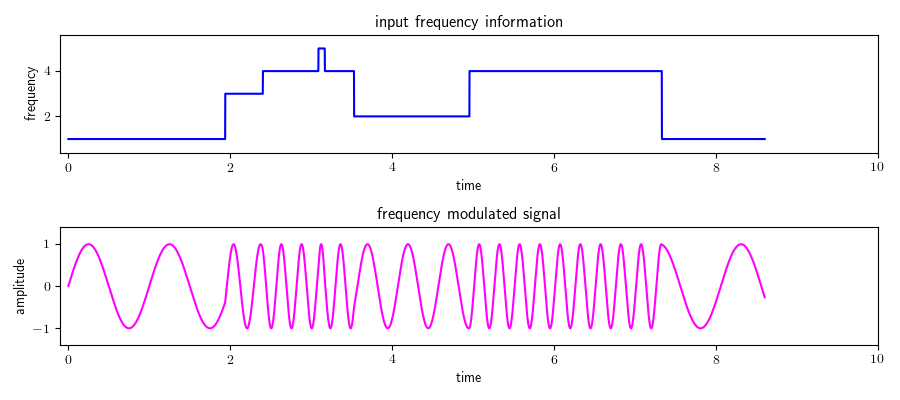
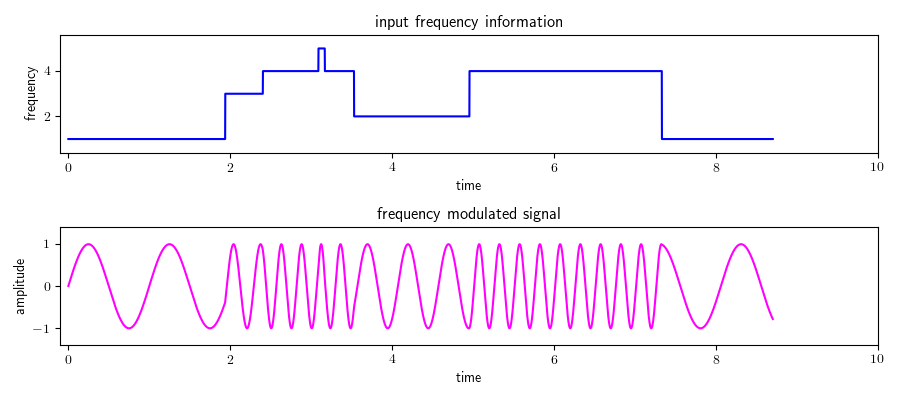
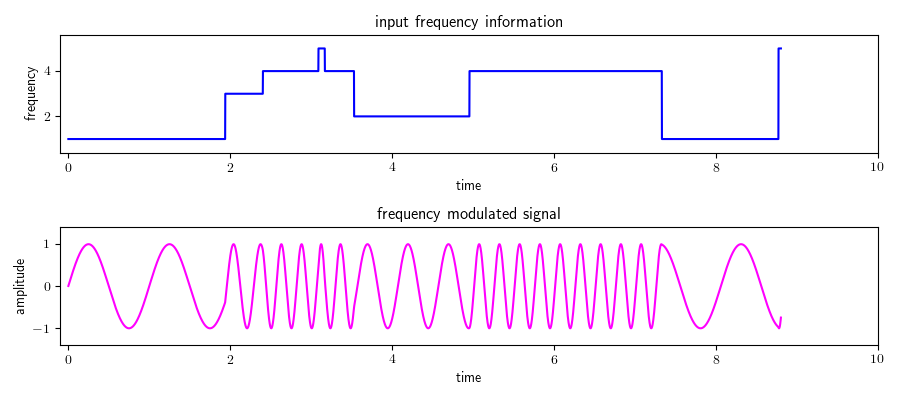
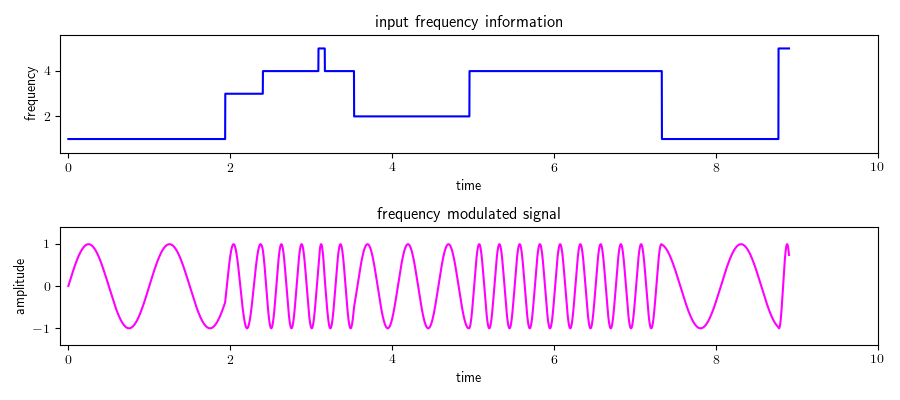
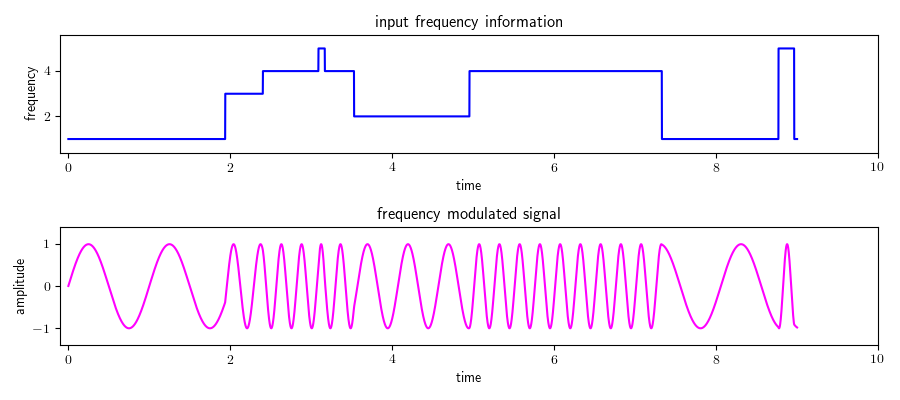
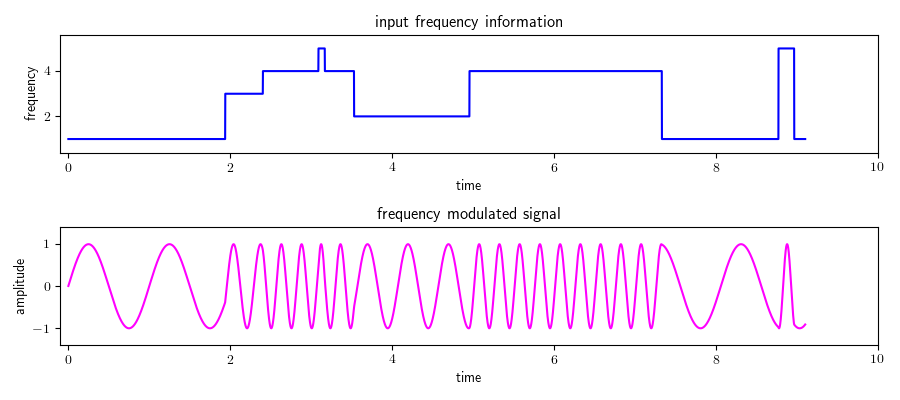
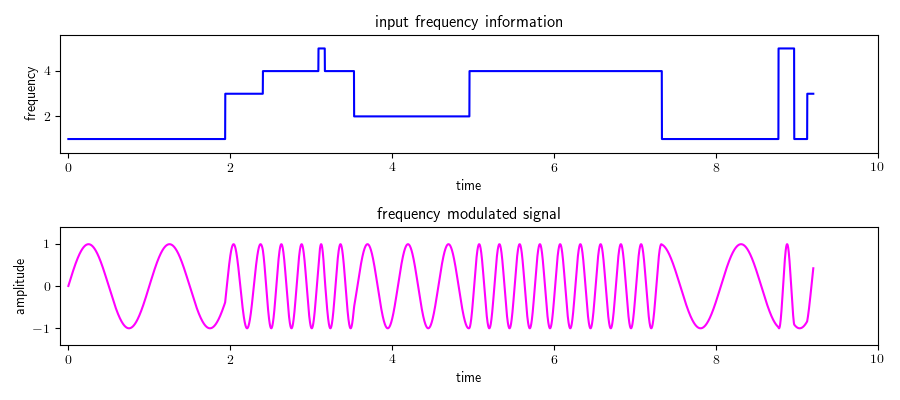
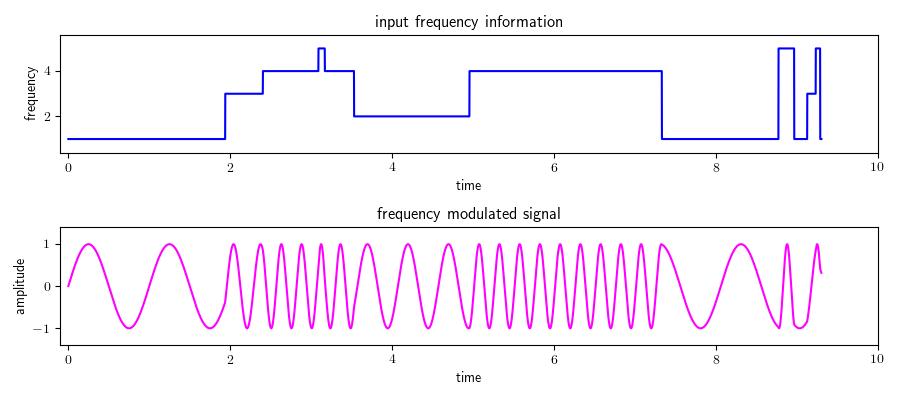
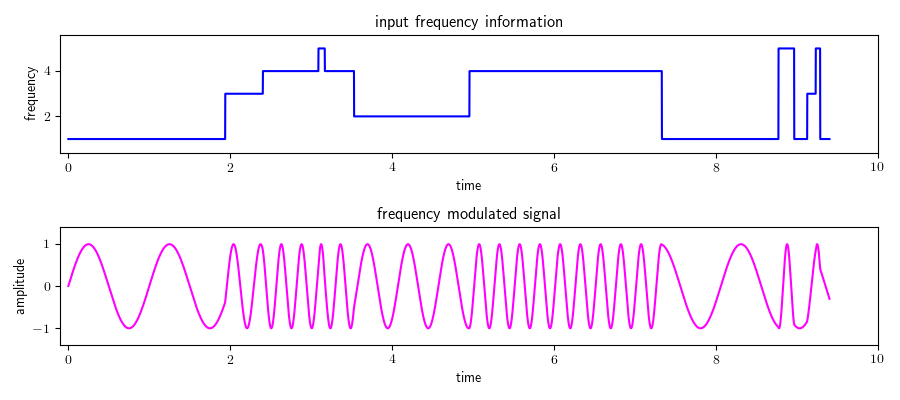
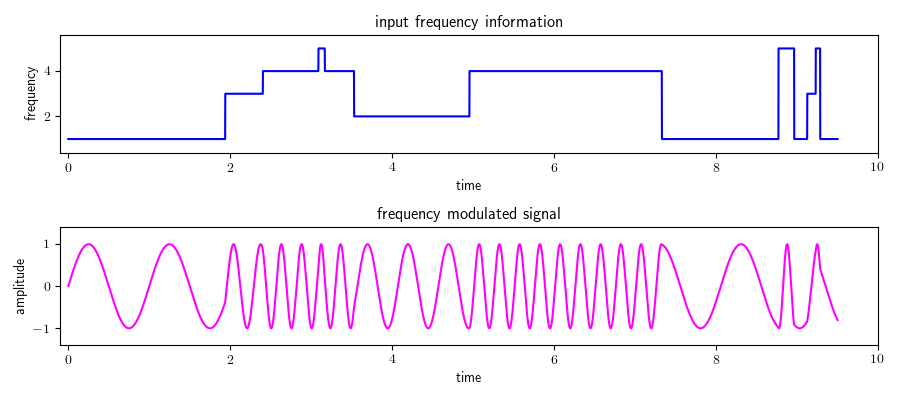
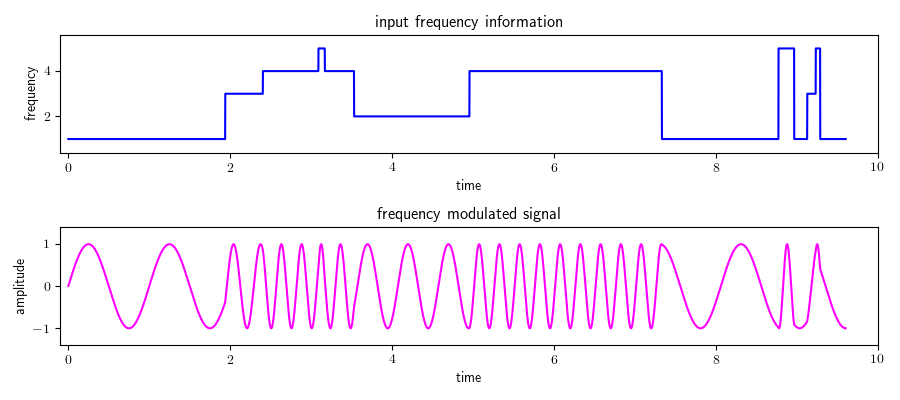
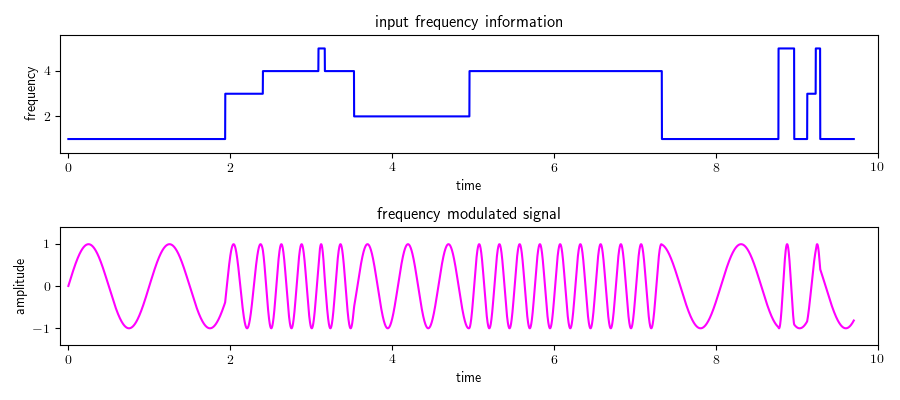
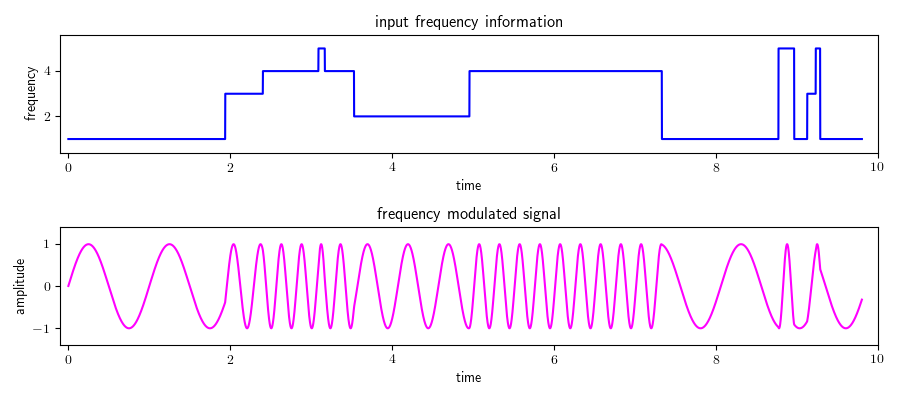
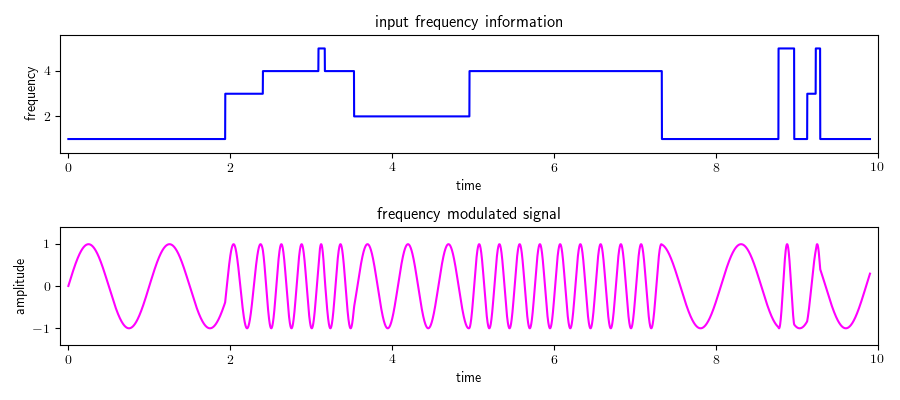

In [115]:
frames = 100
demo = recurlib.fm_animator.Visualizer()
demo.animate_fm_modulation(t,f,correct_signal,frames)

Correctly modulated.

<IPython.core.display.Javascript object>


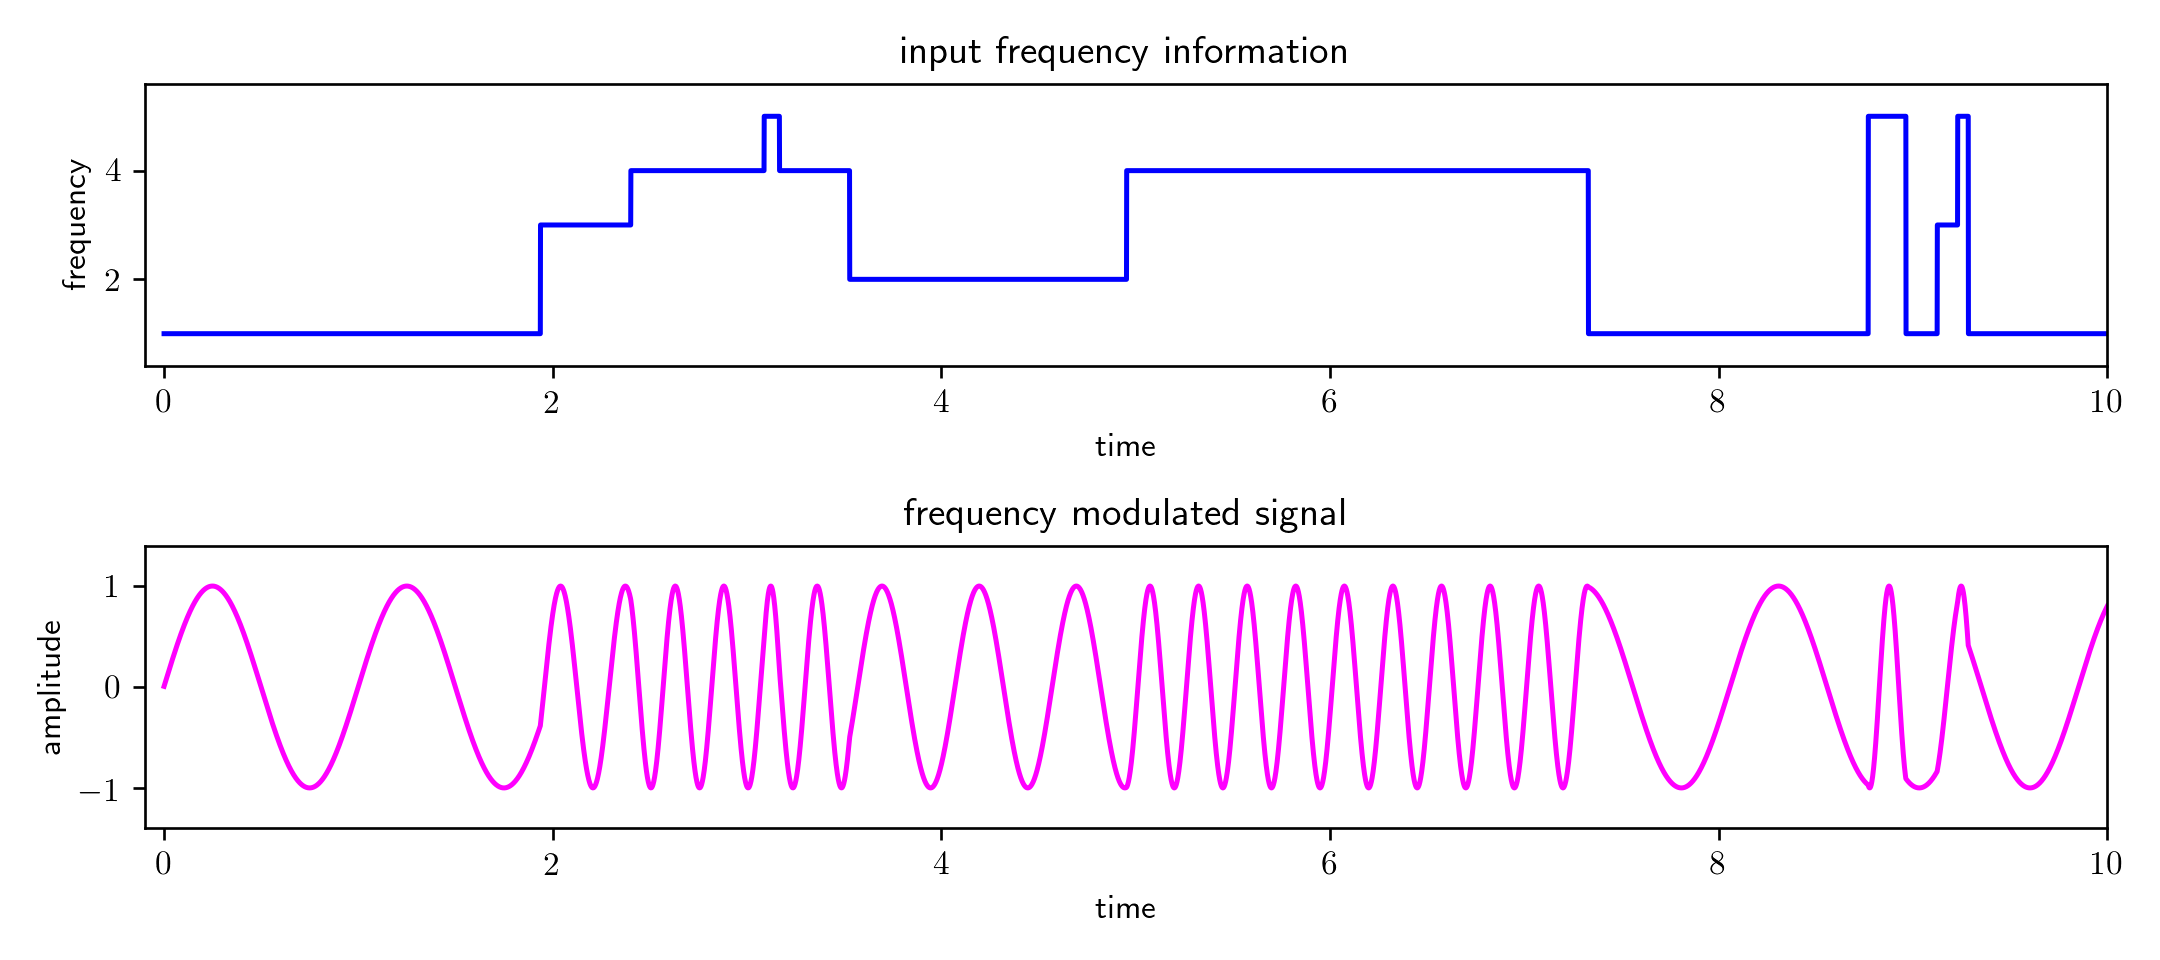

In [113]:
demo = recurlib.fm_animator.Visualizer()
demo.static_fm_modulation(t,f,correct_signal)

Incorrectly modulated.

<IPython.core.display.Javascript object>


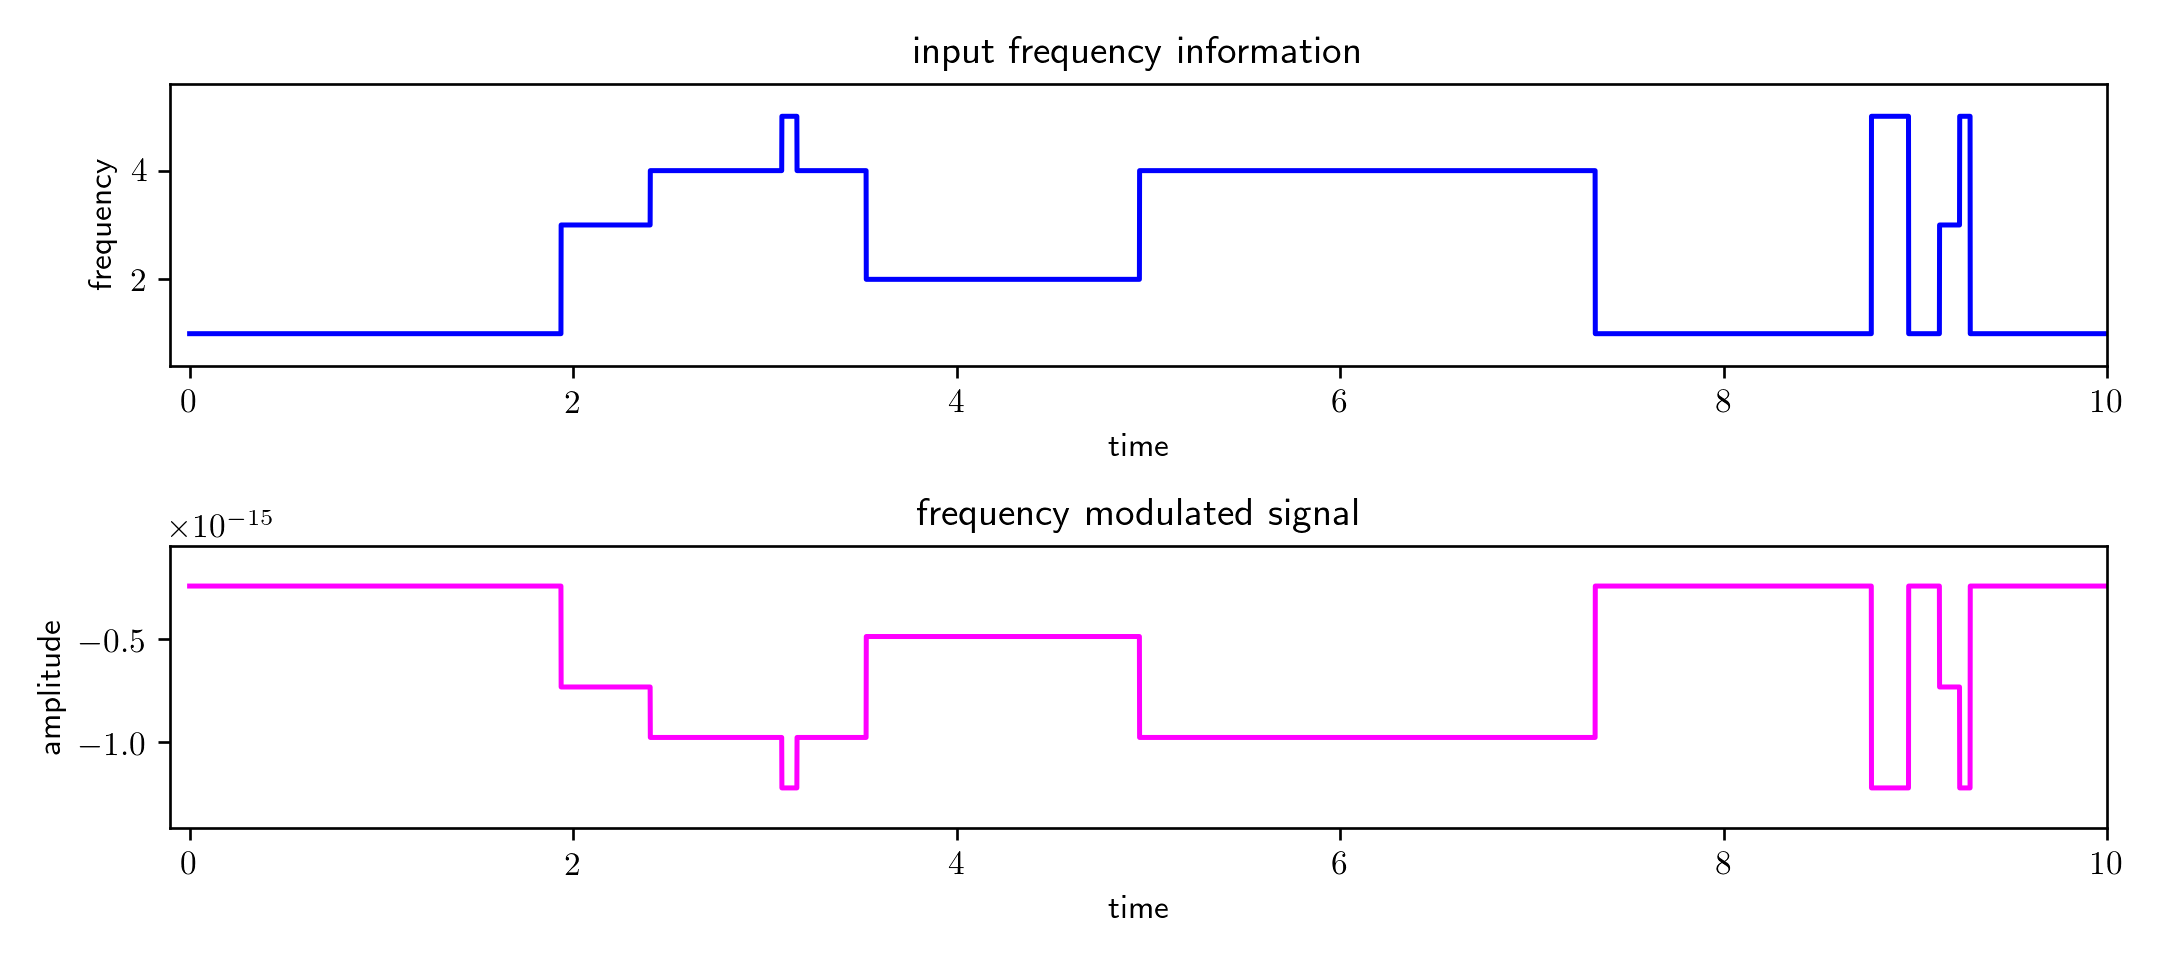

In [114]:
demo = recurlib.fm_animator.Visualizer()
demo.static_fm_modulation(t,f,incorrect_signal)

## 15.1.1  Order is a kind of structure we have yet to leverage 

#### <span style="color:#a50e3e;">Example 1. </span> Financial time series

In [ ]:
# animate order
# for stock data
demo.single_plot(xc,yc)

If we closely analyze the update step for any given dynamic system like the ones above, we can see that *absolutely every point is directly related to the initial condition $x_1$*.  How?  If we know that $x_3$ is related to its predecssor as 

\begin{equation}
x_3 = f\left(x_2\right)
\end{equation}

and $x_2$ is related to the initial condition similarly as

\begin{equation}
x_2 = f\left(x_1\right)
\end{equation}

then plugging in the form of $x_2$ above into the relationship describing $x_3$ we have that

\begin{equation}
x_3 = f\left(x_2\right) = f\left(\,f\left(x_1\right)\right).
\end{equation}

In other words, the third point $x_3$ is precisely the initial condition $x_1$ passed through $f$ twice.

This relationship holds more generally as well.  By the same logic we the $p^{th}$ point $x_p$ is directly related to the initial condition by passing it through the function $p-1$ times as

\begin{equation}
x_p = f\left(\,f\left(\,\cdots f\left(x_1\right)\right)\cdots\right).
\end{equation}

In other words, every point generated by a dynamic system without memory is in fact directly related to the initial condition $x_1$ alone.

## Endnotes 

<a id='endnotes'></a>
[1]  We could write the update for our running sums shown above as a dynamic system in the memoryless flavor with a different function at each step - that is we express it using a single update formula - whose order *increases by $1$* at each step like so

\begin{array}
\
h_1 = x_1 \\
h_{p+1} = f\left(x_1,x_2,...,x_{p+1}\right)  \,\,\,\,\,\,p=1,...,P-1
\end{array}

where the function used here is the sum $f\left(x_1,x_2,...,x_{p+1}\right) = \sum_{t=1}^{p+1}x_t$ changes from step to step.  This sort of dynamic system representation of the running sums sequence differs from those memoryless dynamic systems we saw in the previous Section - it has *complete memory* of the entire input sequence at each update step. 

[2]  Note now that we started off our running sum with $h_1 = 0$ so that both indecies on the right hand side of our $P$ updates are indexed on $p$ (otherwise, if we started above with $h_1 = x_1$ we would have ended up with the somewhat awkwardly indexed update $h_{p+1} = h_p + x_{p+1}$).